# Attack attempt, training both G and D in the GAN, using all classes to train the G

First attempt at training the GAN D/G to provide **valid** and **representable** data from unknown classes

## Imports

In [1]:
import tensorflow as tf
# tf.enable_eager_execution() # default for TF 2.0

tf.keras.backend.clear_session()  # For easy reset of notebook state.
from tensorflow import keras  # Import the tf version of keras.
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, \
                                    LeakyReLU, Conv2DTranspose, Reshape
# import keras.backend as K
from tensorflow.keras.datasets import mnist

print('TF', tf.__version__)
print('Keras', keras.__version__)

TF 2.1.0
Keras 2.2.4-tf


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
import pickle
from glob import glob
from pprint import pprint

import os.path
import shutil
import math
import random
from copy import copy, deepcopy

In [3]:
# Setting seeds for reproducibility 
np.random.seed(0)
tf.random.set_seed(0)

# Enlargen plots
plt.rcParams['figure.figsize'] = [10, 5]

## Parameters

In [4]:
# EASY_MODE: if True, Split Learning NN is used as the Discriminator in the GAN. This is good for testing, but
# bypasses the black-box paradigm! Use with caution
EASY_MODE = True

# Black-box params (optimized for MNIST)
depth = 9
filters = 33
dense = 110
num_classes = 10

# Input image dimensions
img_rows, img_cols = 28, 28
target_rows, target_cols = 28, 28    # governed by the chosen model
input_shape = (target_rows, target_cols, 1)

# Split Learning training params:
split_training_params = {
    'minibatch_size': None,                     # number of samples to operate on at one time
                                                #  - can vary to optimize computing requirements
                                                #  - if None, will evaluate the client's whole batch regardless of its size
    'apply_gradients_after': 20,                # after averaging the gradients from X clients, we will apply them to the model
    'epochs': 25,                               # number of epochs to train for
    'shuffle_clients': True,                    # whether to shuffle the clients during training
    'eval_batch_size': 256,                     # batch size when evaluating test set (not split by clients),
    'train_dataset': None,                      # training set - indexed by client
    'test_dataset': None,                       # testing set - not batched
    'ckpt_folder': "blackbox_checkpoint",       # folder where to store the checkpoints
}

# GAN training params:
gan_training_params = {
    'batch_size': 256,                          # number of images to generate from G at once
    'noise_dim': 100,                           # noise vector for G
    'epochs': 300,                              # number of epochs to train GAN
    'use_blackbox': True,                       # if True, copies the Blackbox model into D (easy check)
    'd_ckpt_folder': "discriminator_checkpoint",# folder where to store the d checkpoints
    'bb_ckpt_folder': "blackbox_checkpoint",    # folder where the blackbox default ckpt is kept
    'g_ckpt_folder': "generator_checkpoint",    # folder where to store the g checkpoints
    'batches_per_epoch': 200,                   # number of batches to train on per epoch
    'd_trigger': 0.98,                          # train D if g_accuracy is >= X
    'g_trigger': 0.98,                          # train G if g_accuracy is < X
    'softmax_power': 4,                         # number used in softmax -> onehot encoding operation
    'loop_times': 0,                            # number of times to apply softmax -> onehot encoding
    'd_reset_percentage': 1.0,                  # reset D if the test d_accuracy dips below X% of the original accuracy
    'early_stop_trigger': 20,                   # stop training early, if g_accuracy has not improved for X epochs
    'stop_sensitivity': 0.01,                   # "no improvement" is when the g_accuracy has not moved more than X% from prev
    'g_nudge_trigger': 10,                      # if "no improvement" for X epochs, turn on D for one turn
    'g_nudge_probability': 0.20,                # probability of nudging this sample, if enabled
}

# Data parsing params
clients_per_class = 100                         # number of clients per label. Each client only has access to one label
                                                # - each unique class is divided into X number of subsets

# Dataset params
separated_folder = "./separated_dataset"
os.makedirs(separated_folder, exist_ok=True)
separated_train_path = os.path.join(separated_folder, "train_separated.pkl")
separated_test_path = os.path.join(separated_folder, "test_separated.pkl")

## Load Data

In [5]:
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = (x_train - 127.5) / 127.5 # Normalize the images to [-1, 1]
# x_train /= 255    # range is [0, 1]
x_test = (x_test - 127.5) / 127.5 # Normalize the images to [-1, 1]
# x_test /= 255     # range is [0, 1]

if target_rows != img_rows or target_cols != img_cols:
    # resize x_train
    x_train_resized = []
    for x_ in x_train:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_train_resized.append(x_)
    x_train = np.asarray(x_train_resized)

    # resize x_test
    x_test_resized = []
    for x_ in x_test:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_test_resized.append(x_)
    x_test = np.asarray(x_test_resized)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
# summary of data shapes:
print('X:', x_train.shape, x_test.shape)
print('y:', y_train.shape, y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

BUFFER_SIZE = x_train.shape[0]

X: (60000, 28, 28, 1) (10000, 28, 28, 1)
y: (60000, 10) (10000, 10)
60000 train samples
10000 test samples


#### Separate the data by class

In [7]:
# Separating the data by class
if os.path.isfile(separated_train_path):
    with open(separated_train_path, 'rb') as f:
        x_train_dict, y_train_dict = pickle.load(f)
        print('loaded training seperation')
else:
    x_train_dict = {}
    y_train_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_train_dict[target_label] = []
        y_train_dict[target_label] = []
        for i, label in enumerate(y_train):
            if list(label).index(1) == target_label:
                x_train_dict[target_label].append(x_train[i])
                y_train_dict[target_label].append(y_train[i])
    
    with open(separated_train_path, 'wb') as f:
        pickle.dump([x_train_dict, y_train_dict], f)
        print('saved training seperation')

if os.path.isfile(separated_test_path):
    with open(separated_test_path, 'rb') as f:
        x_test_dict, y_test_dict = pickle.load(f)
        print('loaded testing seperation')
else:
    x_test_dict = {}
    y_test_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_test_dict[target_label] = []
        y_test_dict[target_label] = []
        for i, label in enumerate(y_test):
            if list(label).index(1) == target_label:
                x_test_dict[target_label].append(x_test[i])
                y_test_dict[target_label].append(y_test[i])

    with open(separated_test_path, 'wb') as f:
        pickle.dump([x_test_dict, y_test_dict], f)
        print('saved testing seperation')
    
# convert dicts to lists
x_train_seperated = [np.array(x_train_dict[i]) for i in range(10)]
y_train_seperated = [np.array(y_train_dict[i]) for i in range(10)]

x_test_seperated = [np.array(x_test_dict[i]) for i in range(10)]
y_test_seperated = [np.array(y_test_dict[i]) for i in range(10)]

loaded training seperation
loaded testing seperation


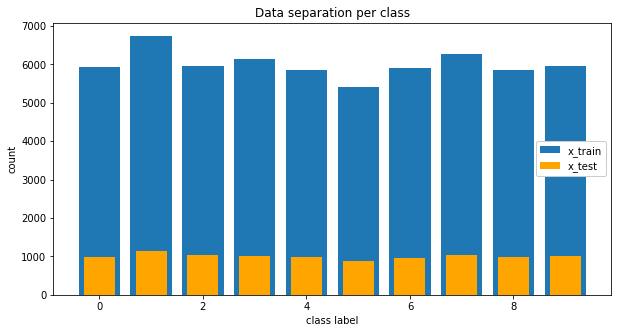

In [8]:
# summary of data shapes:
plt.figure()
plt.title('Data separation per class')
plt.bar(x_train_dict.keys(), [len(v) for v in x_train_dict.values()], color='tab:blue')
plt.bar(x_test_dict.keys(), [len(v) for v in x_test_dict.values()], color='orange', width=0.6)
plt.legend(['x_train', 'x_test'], loc='center right', framealpha=1.0)
plt.xlabel('class label')
plt.ylabel('count')
plt.show()

#### Separate the data into batches for clients to use

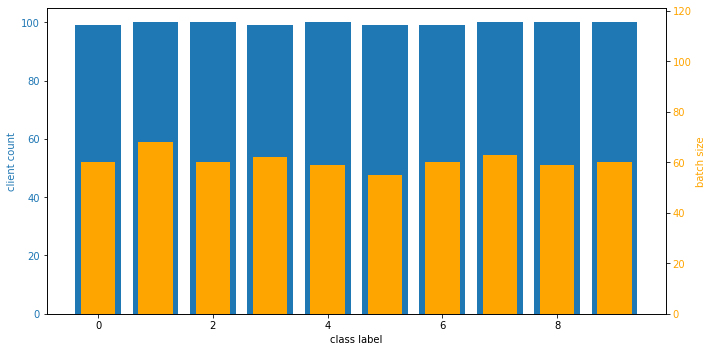

Clients per class:  99.6 ~= 100
Total number of clients: 996
Average batch size: 60.6


In [9]:
# Separate the data into a long list of batches, each batch representing a client training with that batch of images.
# After each batch, a new client will have the opportunity to train their batch of images.
# Batches are shuffled to simulate many clients training the model at once.

client_counts = {}
batch_sizes = {}
x_batches = []
y_batches = []

def ceil(a,b):
    return -(-a//b)

for class_idx in range(len(x_train_seperated)):
    # Get batches from class data:
    n_samples_per_class = len(x_train_seperated[class_idx])
    samples_per_client = n_samples_per_class / clients_per_class
    better_batch_size = int(math.ceil(samples_per_client))

    count = 0
    for i in range(ceil(n_samples_per_class, better_batch_size)):
        x_batches.append((class_idx, x_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        y_batches.append((class_idx, y_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        count += 1
    client_counts[class_idx] = count
    batch_sizes[class_idx] = better_batch_size
        
# double check that the clients_per_class is upheld per class
# (blue bars should be uniform, orange should change according to class):
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('class label')
ax1.set_ylabel('client count', color=color)
plt.bar(client_counts.keys(), [v for v in client_counts.values()], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'orange'
ax2.set_ylabel('batch size', color=color)  # we already handled the x-label with ax1
plt.bar(batch_sizes.keys(), [v for v in batch_sizes.values()], color=color, width=0.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, np.mean([v for v in batch_sizes.values()])*2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

print('Clients per class:  {} ~= {}'.format(np.mean([v for v in client_counts.values()]), clients_per_class))
print('Total number of clients: {}'.format(np.sum([v for v in client_counts.values()])))
print('Average batch size: {}'.format(np.mean([v for v in batch_sizes.values()])))

split_batch_size = np.floor(np.mean([v for v in batch_sizes.values()]))

#### Batch and shuffle automatically

In [10]:
# Batch and shuffle the data for Split Learning
split_train_dataset = (x_batches, y_batches)
split_test_dataset = (x_test, y_test)

# place into train params:
split_training_params['train_dataset'] = split_train_dataset
split_training_params['test_dataset'] = split_test_dataset

## Build Model

In [11]:
# FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=

def start_piece_(input_shape, filters=4):
    assert filters >= 1
    
    model = tf.keras.Sequential()
    model.add(Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
    
    return model

def blackbox_piece_(model, depth=1, filters=4):
    assert depth >= 1
    assert filters >= 1
    
    # for now, we will just give the black-box all the CNN layers
    for i in range(depth-1):
        model.add(Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same'))
    
    return model

def approximator_piece_(model, depth=1, filters=4):
    assert depth >= 1
    assert filters >= 1
    
    # for now, we will just give the approximator_piece piece the same complexity as bb (since we have shown it doens't matter)
    model = blackbox_piece_(model, depth, filters)
    
    return model

def end_piece_(model, dense_breadth=128, num_classes=10):
    assert dense_breadth >= num_classes
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(dense_breadth, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

## Graph Creation

In [12]:
# Ensure the params are acceptable:
assert depth >= 1
assert filters >= 1
assert dense >= num_classes

In [13]:
class SplitLearning:
    
    def __init__(self, split_training_params):
        self.minibatch_size = split_training_params['minibatch_size']
        self.batches_per_train_step = split_training_params['apply_gradients_after']
        self.eval_batch_size = split_training_params['eval_batch_size']
        self.shuffle_clients = split_training_params['shuffle_clients']
        self.ckpt_folder = split_training_params['ckpt_folder']
        
        # define the NN model
        self.model = self.blackbox_model()
        
        # define loss function
        self.cross_entropy = keras.losses.CategoricalCrossentropy(from_logits=True)
        
        # define optimizers
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        
        # define metrics
        self.acc_train_avg = None
        self.loss_train_avg = None
        
        # setup checkpointing
        self.init_ckpt()
        
        # setup ops
        self.setup_ops()
        
    ###########################################################################################
    # Black-box model
        
    def blackbox_model(self):
        model = start_piece_(input_shape, filters)
        model = blackbox_piece_(model, depth, filters)
        model = end_piece_(model, dense, num_classes)
        return model
    
    def model_loss(self, y_true, y_pred):
        return self.cross_entropy(y_true, y_pred)
        
    ###########################################################################################
    # Train
    
    def setup_ops(self):
        # INSPIRED BY: https://stackoverflow.com/questions/42156957/how-to-update-model-parameters-with-accumulated-gradients
        # https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough
        
        self.tvs = self.model.trainable_variables
        self.accum_vars = [tf.Variable(tf.zeros_like(tv.initialized_value()), trainable=False) for tv in self.tvs]
        self.accum_counter = tf.Variable(0.0, trainable=False)
    
    def train(self, dataset, iteration):
        # setup checkpointing
        self.setup_ckpt(iteration)
        
        # initialize the metrics each new epoch
        if self.acc_train_avg is not None:
            del self.acc_train_avg
        if self.loss_train_avg is not None:
            del self.loss_train_avg
        self.acc_train_avg = tf.keras.metrics.Accuracy()
        self.loss_train_avg = tf.keras.metrics.Mean()
        
        x_batches, y_batches = dataset
        pbar = tqdm_notebook(total=len(x_batches))
        
        batch_idxs = list(range(len(x_batches)))
        if self.shuffle_clients:
            # shuffle the batches each time
            random.shuffle(batch_idxs)
            
        for i, batch_idx in enumerate(batch_idxs):
            x_batch = x_batches[batch_idx][1]
            y_batch = y_batches[batch_idx][1]
            
            self.train_step(i, x_batch, y_batch, len(batch_idxs) - 1)
            pbar.update(1)
            pbar.set_description('train_acc={:.2f}%'.format(self.acc_train_avg.result()*100))
        pbar.close()
        
        # save checkpoints
        self.checkpoint()
        
    def train_step(self, i, x_batch, y_batch, limit):
        # Iterate over the client's batch in minibatches:
        j = 0
        while(j < len(x_batch)):
            if self.minibatch_size is None:
                # use whole batch (no minibatch)
                x_minibatch = x_batch
                y_minibatch = y_batch
            else:
                x_minibatch = x_batch[j:(j+self.minibatch_size)]
                y_minibatch = y_batch[j:(j+self.minibatch_size)]

            # run the gradients
            loss_value, grads = self.grad(x_minibatch, y_minibatch)

            # accumulate them
            self.accumulate_grads(grads)

            if self.minibatch_size is None:
                break
            else:
                j += self.minibatch_size

        # perform a train step every batches_per_train_step number of batches:
        if (i > 0 and i % self.batches_per_train_step == 0) or i == limit:
            # Run the train_step ops to update the weights based on our accumulated gradients
            self.optimize()
            self.zero_out()
    
    def grad(self, inputs, targets):
        with tf.GradientTape() as tape:
            logits = self.model(inputs, training=True)
            loss_value = self.model_loss(targets, logits)
            
        # evaluate accuracy and append acc and loss to arrays
        self.acc_train_avg(tf.argmax(targets, 1), tf.argmax(logits, 1))
        self.loss_train_avg(loss_value)
        
        return loss_value, tape.gradient(loss_value, self.model.trainable_variables)
    
    def accumulate_grads(self, grads):
        # add to accum_vars the new gradients
        self.accum_vars = [self.accum_vars[i].assign_add(grad) for i, grad in enumerate(grads)]
        # increment the counter by 1
        self.accum_counter.assign_add(1.0)
        
    def optimize(self):
        # apply the gradients in accum_vars, dividing by the number in accum_counter
        self.optimizer.apply_gradients(
            [(accum_var / self.accum_counter, tv) \
                for (accum_var, tv) in zip(self.accum_vars, self.model.trainable_variables)]
        )
    
    def zero_out(self):
        # reset accum_vars and accum_counter back to 0
        self.accum_vars = [tv.assign(tf.zeros_like(tv)) for tv in self.accum_vars]
        self.accum_counter = tf.Variable(0.0, trainable=False)
        
    ###########################################################################################
    # Checkpoint
    
    def init_ckpt(self):
        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        self.manager = None
        self.internal_iteration = None
        self.iteration_offset = 0
        
    def setup_ckpt(self, iteration):
        # setup fresh checkpointer every new iteration
        if self.internal_iteration is None or iteration != self.internal_iteration - self.iteration_offset:
            ckpt_save_folder = os.path.join('checkpoints', 'it_{}'.format(iteration + self.iteration_offset), self.ckpt_folder)
            os.makedirs(ckpt_save_folder, exist_ok=True)
        
            if self.ckpt is not None:
                del self.ckpt
            if self.manager is not None:
                del self.manager

            self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
            self.manager = tf.train.CheckpointManager(self.ckpt, ckpt_save_folder, max_to_keep=1)
            self.internal_iteration = iteration + self.iteration_offset
    
    def checkpoint(self):
        save_path = self.manager.save()
        print("Saved checkpoint: {}".format(save_path))
        
    def restore(self, it_restore=None, load_default=False):
        parent_folder = os.path.join('checkpoints')
        if it_restore is None and not load_default:
            # find the most recent iteration and checkpoint
            largest_it = None
            for d in glob(os.path.join(parent_folder, '*')):
                if os.path.isfile(os.path.join(d, self.ckpt_folder, 'checkpoint')):
                    # passed, valid checkpoint
                    if '_' in d:
                        # passed, valid iteration folder
                        it = int(d.split('_')[1])
                        if largest_it is None or it > largest_it:
                            largest_it = it
            if largest_it is not None:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(largest_it), self.ckpt_folder)
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                self.iteration_offset = largest_it
                print('Restored latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found, starting with a fresh network')
        else:
            if load_default:
                checkpoint_directory = os.path.join(parent_folder, 'default', self.ckpt_folder)
            else:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(it_restore), self.ckpt_folder)
            if os.path.isfile(os.path.join(checkpoint_directory, 'checkpoint')):
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                if it_restore is not None:
                    self.iteration_offset = it_restore
                print('Restored latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found at: {}'.format(checkpoint_directory))
        
    ###########################################################################################
    # Evaluate
        
    def evaluate(self, dataset):
        
        x, y = dataset
        
        acc_test_avg = tf.keras.metrics.Accuracy()
        loss_test_avg = tf.keras.metrics.Mean()
        for i in range(0, len(x), self.eval_batch_size):
            # get batch
            x_batch = x[i:i+self.eval_batch_size]
            y_batch = y[i:i+self.eval_batch_size]
            
            # evaluate
            logits = self.model(x_batch, training=False)
            acc_test_avg(tf.argmax(y_batch, 1), tf.argmax(logits, 1))
            loss_test_avg(self.model_loss(y_batch, logits))
        
        if self.acc_train_avg is not None and self.loss_train_avg is not None:
            print('Train Accuracy: {:.3f} | Loss: {:.3f}'.format(self.acc_train_avg.result(), self.loss_train_avg.result()))
        print('Test Accuracy: {:.3f} | Loss: {:.3f}'.format(acc_test_avg.result(), loss_test_avg.result()))
        print()

In [14]:
class D:
    '''
    The Discriminator portion of the GAN. Accepts a network, otherwise creates a new model.
    '''
    
    def __init__(self, gan_training_params, discriminator=None):
        
        self.ckpt_folder = gan_training_params['d_ckpt_folder']
        self.bb_ckpt_folder = gan_training_params['bb_ckpt_folder']
        self.loop_times = gan_training_params['loop_times']
        self.softmax_power = gan_training_params['softmax_power']
        
        # make FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=
        if discriminator is not None:
            self.model = discriminator
        else:
            self.model = self.discriminator_model()
            
        # define optimizers
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        
        # define entropies
        self.cat_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        self.bin_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
            
        # setup checkpointing
        self.ckpt = None
        self.manager = None
        
    ###########################################################################################
    # Discriminator model
    
    def discriminator_model(self):
        model = start_piece_(input_shape, filters)
        model = approximator_piece_(model, depth, filters)
        model = end_piece_(model, dense, num_classes)
        return model
        
    ###########################################################################################
    # Loss
    
    def loss(self, fake_discrimination, labels):
        matches = self.matches_labels(fake_discrimination, labels, loop_times=self.loop_times)
        # we want the discriminator to NOT be fooled by these fake images
        cross_entropy = self.bin_cross_entropy(tf.zeros_like(matches), matches)
        return cross_entropy
    
    def entropy(self, y_true, y_pred):
        return self.cat_cross_entropy(y_true, y_pred)
        
    def matches_labels(self, fake_output, labels, loop_times=0):
        '''
        Only works if the Discriminator is already trained on real images!!
        1. Performs a softmax -> onehot conversion (differentiable approx.)
        2. Multiplies this by the onehot version of the onehot attack label
        3. Sums to reduce dimension
        
        - if the sum is close to 1, the nn thinks that the image is a part of the attack class
        - if the sum is close to 0, the nn thinks that the image is not of the attack class
        - the sum should not be in between, due to the onehot conversion we perform in step 1
        '''
        # 1.
        my_power = self.softmax_power
        for i in range(loop_times):
            fake_output = self.soft_onehot(fake_output)
        
        # 2.
        matches = tf.math.multiply(fake_output, labels)
        
        # 3.
        reduced = tf.math.reduce_sum(matches, axis=-1)
        
        return reduced
        
    def soft_onehot(self, softmax, my_power=8):
        '''
        Shown to not really work... vanishing gradients problem
        '''
        soft_extreme = softmax ** my_power
        norm = tf.reduce_sum(soft_extreme, axis=-1)
        almost_onehot = tf.math.divide(soft_extreme, tf.reshape(norm, (-1, 1)))
        return almost_onehot
    
    ###########################################################################################
    # Checkpoint
    
    def init_ckpt(self):
        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        
    def setup_ckpt(self, iteration):
        ckpt_save_folder = os.path.join('checkpoints', 'it_{}'.format(iteration), self.ckpt_folder)
        os.makedirs(ckpt_save_folder, exist_ok=True)

        if self.ckpt is not None:
            del self.ckpt
        if self.manager is not None:
            del self.manager

        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        self.manager = tf.train.CheckpointManager(self.ckpt, ckpt_save_folder, max_to_keep=1)
        
    def checkpoint(self):
        save_path = self.manager.save()
        print("Saved D checkpoint: {}".format(save_path))
        
    def restore(self, it_restore=None, load_default=False, use_blackbox=False):
        iteration_offset = 0
        parent_folder = os.path.join('checkpoints')
        if it_restore is None and not load_default:
            # find the most recent iteration and checkpoint
            largest_it = None
            for d in glob(os.path.join(parent_folder, '*')):
                if os.path.isfile(os.path.join(d, self.ckpt_folder, 'checkpoint')):
                    # passed, valid checkpoint
                    if '_' in d:
                        # passed, valid iteration folder
                        it = int(d.split('_')[1])
                        if largest_it is None or it > largest_it:
                            largest_it = it
            if largest_it is not None:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(largest_it), self.ckpt_folder)
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                iteration_offset = largest_it
                print('Restored D to latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found for D, starting with a fresh network')
        else:
            if load_default:
                if use_blackbox:
                    checkpoint_directory = os.path.join(parent_folder, 'default', self.bb_ckpt_folder)
                else:
                    checkpoint_directory = os.path.join(parent_folder, 'default', self.ckpt_folder)
            else:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(it_restore), self.ckpt_folder)
            if os.path.isfile(os.path.join(checkpoint_directory, 'checkpoint')):
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                if it_restore is not None:
                    iteration_offset = it_restore
                print('Restored D to latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found at: {}'.format(checkpoint_directory))
        return iteration_offset
        
    ###########################################################################################
    # Evaluation

    def discriminate(self, generated_images, training=True):
        return self.model(generated_images, training=training)

In [15]:
class G:
    '''
    The Generator portion of the GAN. Generates images given a conditional label.
    '''
    
    def __init__(self, gan_training_params):
        self.ckpt_folder = gan_training_params['g_ckpt_folder']
        self.noise_dim = gan_training_params['noise_dim']
        
        # make FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=
        self.model = self.generator_model()
            
        # define optimizers
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        
        # define entropies
        self.cat_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        self.bin_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
            
        # setup checkpointing
        self.ckpt = None
        self.manager = None
        
    ###########################################################################################
    # Generator model
    
    def generator_model(self):
        ACTIVATION = keras.layers.Activation("tanh")
        
        # Prepare noise input
        input_z = keras.layers.Input((self.noise_dim,))
        dense_z_1 = keras.layers.Dense(1024)(input_z)
        act_z_1 = ACTIVATION(dense_z_1)
        dense_z_2 = keras.layers.Dense(128 * 7 * 7)(act_z_1)
        bn_z_1 = keras.layers.BatchNormalization()(dense_z_2)
        reshape_z = keras.layers.Reshape((7, 7, 128), input_shape=(128 * 7 * 7,))(bn_z_1)

        # Prepare Conditional (label) input
        input_c = keras.layers.Input((num_classes,))
        dense_c_1 = keras.layers.Dense(1024)(input_c)
        act_c_1 = ACTIVATION(dense_c_1)
        dense_c_2 = keras.layers.Dense(128 * 7 * 7)(act_c_1)
        bn_c_1 = keras.layers.BatchNormalization()(dense_c_2)
        reshape_c = keras.layers.Reshape((7, 7, 128), input_shape=(128 * 7 * 7,))(bn_c_1)

        # Combine input source
        concat_z_c = keras.layers.Concatenate()([reshape_z, reshape_c])

        # Image generation with the concatenated inputs
        up_1 = keras.layers.UpSampling2D(size=(2, 2))(concat_z_c)
        conv_1 = keras.layers.Conv2D(64, (5, 5), padding='same')(up_1)
        act_1 = ACTIVATION(conv_1)
        up_2 = keras.layers.UpSampling2D(size=(2, 2))(act_1)
        conv_2 = keras.layers.Conv2D(1, (5, 5), padding='same')(up_2)
        act_2 = keras.layers.Activation("tanh")(conv_2)
        model = keras.models.Model(inputs=[input_z, input_c], outputs=act_2)
        return model
        
    ###########################################################################################
    # Loss
    
    def loss(self, fake_discrimination, labels):
        # we want the discriminator to be fooled by these fake images
        cross_entropy = self.cat_cross_entropy(fake_discrimination, labels)
        return cross_entropy
    
    ###########################################################################################
    # Checkpoint
    
    def init_ckpt(self):
        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        
    def setup_ckpt(self, iteration):
        ckpt_save_folder = os.path.join('checkpoints', 'it_{}'.format(iteration), self.ckpt_folder)
        os.makedirs(ckpt_save_folder, exist_ok=True)

        if self.ckpt is not None:
            del self.ckpt
        if self.manager is not None:
            del self.manager

        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        self.manager = tf.train.CheckpointManager(self.ckpt, ckpt_save_folder, max_to_keep=1)
        
    def checkpoint(self):
        save_path = self.manager.save()
        print("Saved G checkpoint: {}".format(save_path))
        
    def restore(self, it_restore=None, load_default=False):
        iteration_offset = 0
        parent_folder = os.path.join('checkpoints')
        if it_restore is None and not load_default:
            # find the most recent iteration and checkpoint
            largest_it = None
            for d in glob(os.path.join(parent_folder, '*')):
                if os.path.isfile(os.path.join(d, self.ckpt_folder, 'checkpoint')):
                    # passed, valid checkpoint
                    if '_' in d:
                        # passed, valid iteration folder
                        it = int(d.split('_')[1])
                        if largest_it is None or it > largest_it:
                            largest_it = it
            if largest_it is not None:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(largest_it), self.ckpt_folder)
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                iteration_offset = largest_it
                print('Restored G to latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found for G, starting with a fresh network')
        else:
            if load_default:
                checkpoint_directory = os.path.join(parent_folder, 'default', self.ckpt_folder)
            else:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(it_restore), self.ckpt_folder)
            if os.path.isfile(os.path.join(checkpoint_directory, 'checkpoint')):
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                if it_restore is not None:
                    iteration_offset = it_restore
                print('Restored G to latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found at: {}'.format(checkpoint_directory))
        return iteration_offset
        
    ###########################################################################################
    # Evaluation
        
    def generate(self, inputs, training=True):
        generated_images = self.model(inputs, training=training)
        return generated_images

In [16]:
class GAN:
    '''
    The GAN. Trains the G and D.
    '''
    
    def __init__(self, gan_training_params, discriminator=None):
        
        self.noise_dim = gan_training_params['noise_dim']
        self.batch_size = gan_training_params['batch_size']
        self.batches_per_epoch = gan_training_params['batches_per_epoch']
        self.d_trigger = gan_training_params['d_trigger']
        self.g_trigger = gan_training_params['g_trigger']
        self.early_stop_trigger = gan_training_params['early_stop_trigger']
        self.stop_sensitivity = gan_training_params['stop_sensitivity']
        self.g_nudge_trigger = gan_training_params['g_nudge_trigger']
        self.g_nudge_probability = gan_training_params['g_nudge_probability']

        # define the D and G models
        self.d = D(gan_training_params, discriminator)
        self.g = G(gan_training_params)
        
        # define metrics
        self.gen_loss_train_avg = None
        self.gen_acc_train_avg = None
        self.disc_loss_train_avg = None
        
        # define plotting metrics
        self.gen_loss_train_arr = []
        self.gen_acc_train_arr = []
        self.disc_loss_train_arr = []
        self.disc_acc_test_arr = []
        
        # seed for image generation
        num_examples_to_generate = 16
        self.seed = tf.random.normal([num_examples_to_generate, self.noise_dim])
        
        # labels for image generation
        label_pattern = [i % (num_classes) for i in range(num_examples_to_generate)]
        self.eval_labels = tf.one_hot(label_pattern, num_classes, dtype=tf.dtypes.float32)
        
        # setup checkpointing
        self.internal_iteration = None
        self.iteration_offset = 0
        self.save_ckpts = True
        
        # initialize d and g checkpoints
        self.d.init_ckpt()
        self.g.init_ckpt()
        
        # setup early stop metrics
        self.early_stop = False
        self.no_change_inc = 0
        self.prev_g_acc = None
        
    ###########################################################################################
    # Trainer
        
    def train(self, iteration):
        # setup checkpointing
        self.setup_ckpts(iteration)
        
        # initialize the metrics each new epoch
        if self.gen_acc_train_avg is not None:
            del self.gen_acc_train_avg
        if self.gen_loss_train_avg is not None:
            del self.gen_loss_train_avg
        if self.disc_loss_train_avg is not None:
            del self.disc_loss_train_avg
        
        self.gen_loss_train_avg = tf.keras.metrics.Mean()
        self.gen_acc_train_avg = tf.keras.metrics.Accuracy()
        self.disc_loss_train_avg = tf.keras.metrics.Mean()
        
        pbar = tqdm_notebook(total=self.batches_per_epoch)
        
        for i in range(self.batches_per_epoch):
            if self.nudge():
                # nudge generator if nothing is happening:
                train_discriminator = True
            else:
                train_discriminator = (self.gen_acc_train_avg.result() >= self.d_trigger)
            train_generator = (self.gen_acc_train_avg.result() < self.g_trigger)
            
            self.train_step(train_discriminator=train_discriminator,
                            train_generator=train_generator)
            pbar.update(1)
            pbar.set_description('g_acc={:.2f}, g_loss={:.2f}, d_loss={:.2f}'.format(self.gen_acc_train_avg.result(),
                                                                                     self.gen_loss_train_avg.result(),
                                                                                     self.disc_loss_train_avg.result()))
        
        # save checkpoints
        self.checkpoint()
        
        # check for early stop
        self.early_stop_check()
    
    def train_step(self, train_discriminator, train_generator):
        noise = tf.random.normal([self.batch_size, self.noise_dim])
        random_classes = tf.random.uniform(shape=(self.batch_size, ), maxval=num_classes, dtype=tf.dtypes.int32)
        labels = tf.one_hot(random_classes, num_classes, dtype=tf.dtypes.float32)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.g.generate([noise, labels], training=train_generator)
            
            # convert the [-1 1] image into [0 1] (due to tanh activation)
            generated_images = 0.5 * generated_images + 0.5

            # we don't evaluate any real images in our case
            #real_output = self.discriminator(images, training=True)
            fake_discrimination = self.d.discriminate(generated_images, training=train_discriminator)

            gen_loss = self.g.loss(fake_discrimination, labels)
            disc_loss = self.d.loss(fake_discrimination, labels)
            
            # evaluate accuracy and append acc and loss to arrays
            self.gen_loss_train_avg(gen_loss)
            self.gen_acc_train_avg(tf.argmax(labels, 1), tf.argmax(fake_discrimination, 1))
            self.disc_loss_train_avg(disc_loss)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.g.model.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.d.model.trainable_variables)

        if train_generator:
            self.g.optimizer.apply_gradients(zip(gradients_of_generator, self.g.model.trainable_variables))
        if train_discriminator:
            self.d.optimizer.apply_gradients(zip(gradients_of_discriminator, self.d.model.trainable_variables))
            
    def nudge(self):
        nudge = False
        if self.no_change_inc >= self.g_nudge_trigger:
            nudge = random.random() < self.g_nudge_probability
        return nudge
        
    ###########################################################################################
    # Checkpoint
    
    def setup_ckpts(self, iteration):
        if self.save_ckpts:
            # setup fresh checkpointer every new iteration
            if self.internal_iteration is None or (self.internal_iteration != (iteration + self.iteration_offset)):
                self.internal_iteration = iteration + self.iteration_offset
                self.d.setup_ckpt(self.internal_iteration)
                self.g.setup_ckpt(self.internal_iteration)
    
    def checkpoint(self):
        if self.save_ckpts:
            self.d.checkpoint()
            self.g.checkpoint()
        
    def restore(self, it_restore=None, load_default=False):
        tmp_offset = self.d.restore(it_restore, load_default, use_blackbox=False)
        self.iteration_offset = self.g.restore(it_restore, load_default)
        assert tmp_offset == self.iteration_offset
        
    ###########################################################################################
    # Early stop
        
    def early_stop_check(self):
        if self.prev_g_acc is not None:
            perc_diff = abs(self.gen_acc_train_avg.result() - self.prev_g_acc) / self.prev_g_acc
            if perc_diff <= self.stop_sensitivity:
                self.no_change_inc += 1
                if self.no_change_inc >= self.early_stop_trigger:
                    self.early_stop = True
            else:
                self.no_change_inc = 0
        
        self.prev_g_acc = self.gen_acc_train_avg.result()
        
    ###########################################################################################
    # Evaluate
            
    def generate_images(self):
        # Notice `training` is set to False.
        # This is so all layers run in inference mode (batchnorm).
        
        # make the number of 
        
        predictions = self.g.generate([self.seed, self.eval_labels], training=False)
        predictions = 0.5 * predictions + 0.5

        fig = plt.figure(figsize=(4,4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 255.0, cmap='gray')
            plt.axis('off')

        plt.show()
        
    def evaluate_gan(self, dataset):
        
        if self.gen_acc_train_avg is not None:
            print('G Train Acc:     {:.3f} | Loss: {:.3f}'.format(self.gen_acc_train_avg.result(),
                                                                self.gen_loss_train_avg.result()))
            print('D Train Acc:     NaN   | Loss: {:.3f}'.format(self.disc_loss_train_avg.result()))
        disc_acc_test = self.evaluate_discriminator(dataset)
        
        # define plotting metrics
        self.gen_loss_train_arr.append(self.gen_loss_train_avg.result())
        self.gen_acc_train_arr.append(self.gen_acc_train_avg.result())
        self.disc_loss_train_arr.append(self.disc_loss_train_avg.result())
        self.disc_acc_test_arr.append(disc_acc_test)
        
        return disc_acc_test
        
    def evaluate_discriminator(self, dataset):
        
        x, y = dataset
        
        acc_test_avg = tf.keras.metrics.Accuracy()
        loss_test_avg = tf.keras.metrics.Mean()
        for i in range(0, len(x), self.batch_size):
            # get batch
            x_batch = x[i:i+self.batch_size]
            y_batch = y[i:i+self.batch_size]
            
            # evaluate
            logits = self.d.discriminate(x_batch, training=False)
            acc_test_avg(tf.argmax(y_batch, 1), tf.argmax(logits, 1))
            loss_test_avg(self.d.entropy(y_batch, logits))
            
        print('D Test Accuracy: {:.3f} | Loss: {:.3f}'.format(acc_test_avg.result(), loss_test_avg.result()))
        print()
        
        return acc_test_avg.result()

In [17]:
class SystemTrainer:
    
    def __init__(self, split_training_params, gan_training_params):
        # Split Learning params:
        self.split_epochs = split_training_params['epochs']
        self.split_train_dataset = split_training_params['train_dataset']
        assert self.split_train_dataset is not None
        self.split_test_dataset = split_training_params['test_dataset']
        assert self.split_test_dataset is not None
        
        # GAN params:
        self.gan_epochs = gan_training_params['epochs']
        self.use_blackbox= gan_training_params['use_blackbox']
        self.d_reset_percentage = gan_training_params['d_reset_percentage']
        
        # create the Split Learning Trainer
        self.split = SplitLearning(split_training_params)
        
        # create the GAN Trainer
        if not self.use_blackbox:
            # treat the Split Learning NN as a Black-box
            self.gan = GAN(gan_training_params)
        else:
            # use the Split Learning NN as the GAN's Discriminator as an easy check:
            self.gan = GAN(gan_training_params, discriminator=self.split.model)
        
    def query_blackbox(self):
        '''
        Send images generated by the GAN into the Split Learning model (TODO)
        '''
        pass
    
    def early_stop_check(self):
        '''
        Check if any models have triggers an early stop in their training
        '''
        return self.gan.early_stop
        
    def train_system(self):
        
        iteration = 1
        
        # Train the Split Learning model for 25 epochs:
        print('~'*40)
        print('Training Split Learning')
        for e in tqdm_notebook(range(self.split_epochs)):
            if e == 0:
                print('~'*40)
            self.split.train(self.split_train_dataset, iteration)
            self.split.evaluate(self.split_test_dataset)
            
        if not EASY_MODE:
            # Refine the Discriminator in the GAN, since Split Learning is a Black-box:
            print('~'*40)
            print('Refining Discriminator')
            print('~'*40)
            # TODO
        
        # Train the GAN for X epochs, and see if the generator can produce anything:
        print('~'*40)
        print('Training GAN')
        for e in tqdm_notebook(range(self.gan_epochs)):
            if e == 0:
                print('~'*40)
            self.gan.train(iteration)
            self.gan.generate_images()
            
            if self.early_stop_check():
                break
            
    def train_sl(self):
        iteration = 1
        
        # Train the Split Learning model:
        print('~'*40)
        print('Training Split Learning')
        for e in tqdm_notebook(range(self.split_epochs)):
            if e == 0:
                print('~'*40)
            self.split.train(self.split_train_dataset, iteration)
            self.split.evaluate(self.split_test_dataset)
            
    def train_gan(self, original_disc_acc, reset_d_every_epoch=False):
        
        iteration = 1
        
        # Train the GAN for X epochs, and see if the generator can produce anything:
        print('~'*40)
        print('Training GAN')
        for e in tqdm_notebook(range(self.gan_epochs)):
            if e == 0:
                print('~'*40)
            print('Epoch {}/{}'.format(e+1, self.gan_epochs))
            self.gan.train(iteration)
            self.gan.generate_images()
            
            disc_acc_test = self.gan.evaluate_gan(self.split_test_dataset)
            
            if reset_d_every_epoch or disc_acc_test < original_disc_acc * self.d_reset_percentage:
                # reset D back to the original weights, so as not to diverge D too much over training time
                self.gan.d.restore(load_default=True, use_blackbox=self.use_blackbox)
                self.gan.evaluate_discriminator(self.split_test_dataset)
            
            if self.early_stop_check():
                break
                
    def plot_gan_training(self):
        gen_loss_train_arr = self.gan.gen_loss_train_arr
        gen_acc_train_arr = self.gan.gen_acc_train_arr
        disc_loss_train_arr = self.gan.disc_loss_train_arr
        disc_acc_test_arr = self.gan.disc_acc_test_arr
        
        epochs = list(range(max([len(gen_loss_train_arr), len(gen_acc_train_arr), 
                                 len(disc_loss_train_arr), len(disc_acc_test_arr)])))
        epochs = [e + 1 for e in epochs]
        
        plt.figure()
        plt.title('Generator Loss during Training')
        plt.plot(epochs, gen_loss_train_arr)
        plt.show()
        
        plt.figure()
        plt.title('Generator Accuracy during Training')
        plt.plot(epochs, gen_acc_train_arr)
        plt.show()
        
        plt.figure()
        plt.title('Discriminator Loss during Training')
        plt.plot(epochs, disc_loss_train_arr)
        plt.show()
        
        plt.figure()
        plt.title('Discriminator Accuracy (Test) during Training')
        plt.plot(epochs, disc_acc_test_arr)
        plt.show()

In [18]:
# Iterate over all attack classes to see if we can estimate all classes from D!

def test_SplitLearning(slg):
    print('='*40)
    print('Training Split Learning:')
    print('='*40)
    
    slg.train_sl()
    
    return slg

def test_GAN(slg):
    print('='*40)
    print('Training GAN for attacking ANY class:')
    print('='*40)

    # load pretrained weights if they exist:
    slg.split.restore(load_default=True)# (load_default=True, it_restore=1)
    #slg.gan.restore(load_default=True)# (load_default=True, it_restore=1)
    # slg.gan.save_ckpts = False # don't save the training ckpts for this test

    # This SHOULD have the restored weights from split
    print()
    print('Double checking that the D in the GAN has been trained:')
    original_disc_acc = slg.gan.evaluate_discriminator(slg.split_test_dataset)
    print()

    slg.train_gan(original_disc_acc=original_disc_acc, reset_d_every_epoch=False)
    
    return slg

In [19]:
slg = SystemTrainer(split_training_params, gan_training_params)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


In [20]:
print('split_training_params:')
pprint({i:split_training_params[i] for i in split_training_params if 'dataset' not in i})
print()
print('gan_training_params:')
pprint(gan_training_params)

split_training_params:
{'apply_gradients_after': 20,
 'ckpt_folder': 'blackbox_checkpoint',
 'epochs': 25,
 'eval_batch_size': 256,
 'minibatch_size': None,
 'shuffle_clients': True}

gan_training_params:
{'batch_size': 256,
 'batches_per_epoch': 200,
 'bb_ckpt_folder': 'blackbox_checkpoint',
 'd_ckpt_folder': 'discriminator_checkpoint',
 'd_reset_percentage': 1.0,
 'd_trigger': 0.98,
 'early_stop_trigger': 20,
 'epochs': 300,
 'g_ckpt_folder': 'generator_checkpoint',
 'g_nudge_probability': 0.2,
 'g_nudge_trigger': 10,
 'g_trigger': 0.98,
 'loop_times': 0,
 'noise_dim': 100,
 'softmax_power': 4,
 'stop_sensitivity': 0.01,
 'use_blackbox': True}


Training GAN for attacking ANY class:
Restored latest checkpoint from checkpoints\default\blackbox_checkpoint

Double checking that the D in the GAN has been trained:
D Test Accuracy: 0.762 | Loss: 1.695


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training GAN


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-1
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-1


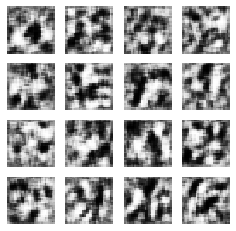

G Train Acc:     0.835 | Loss: 1.626
D Train Acc:     NaN   | Loss: 1.211
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-2
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-2


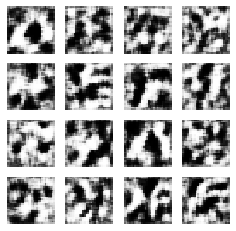

G Train Acc:     0.901 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-3
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-3


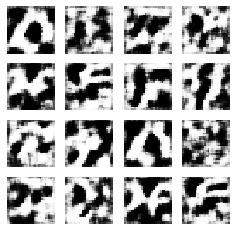

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-4
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-4


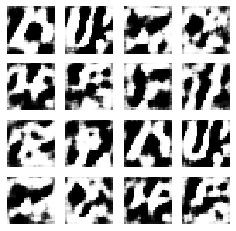

G Train Acc:     0.923 | Loss: 1.538
D Train Acc:     NaN   | Loss: 1.266
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-5
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-5


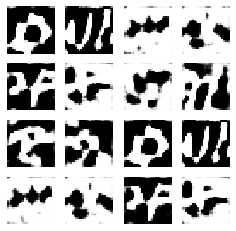

G Train Acc:     0.940 | Loss: 1.522
D Train Acc:     NaN   | Loss: 1.275
D Test Accuracy: 0.319 | Loss: 2.136

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-6


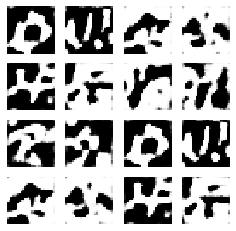

G Train Acc:     0.912 | Loss: 1.549
D Train Acc:     NaN   | Loss: 1.259
D Test Accuracy: 0.493 | Loss: 1.960

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-7


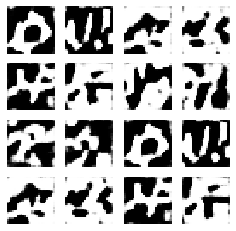

G Train Acc:     0.905 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.466 | Loss: 1.985

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-8


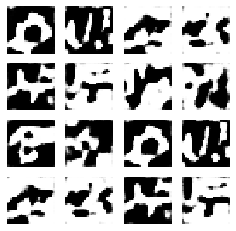

G Train Acc:     0.895 | Loss: 1.566
D Train Acc:     NaN   | Loss: 1.248
D Test Accuracy: 0.826 | Loss: 1.632



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-27
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-9


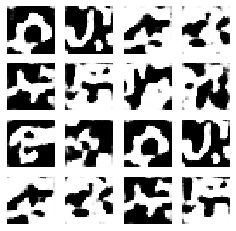

G Train Acc:     0.935 | Loss: 1.526
D Train Acc:     NaN   | Loss: 1.273
D Test Accuracy: 0.826 | Loss: 1.632



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-28
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-10


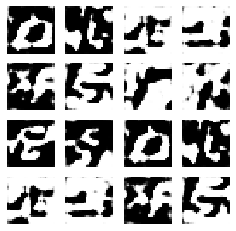

G Train Acc:     0.918 | Loss: 1.544
D Train Acc:     NaN   | Loss: 1.262
D Test Accuracy: 0.437 | Loss: 2.020

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-11


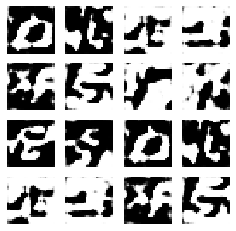

G Train Acc:     0.903 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.560 | Loss: 1.894

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-12


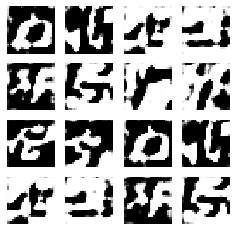

G Train Acc:     0.943 | Loss: 1.518
D Train Acc:     NaN   | Loss: 1.278
D Test Accuracy: 0.374 | Loss: 2.081

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-13


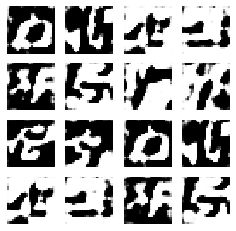

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.508 | Loss: 1.944

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-14


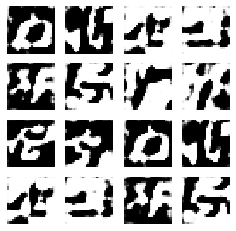

G Train Acc:     0.902 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.605 | Loss: 1.849

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-15


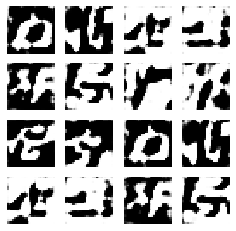

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.478 | Loss: 1.973

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-16


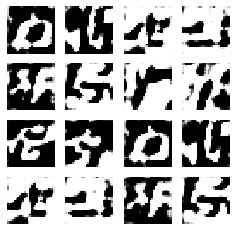

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.608 | Loss: 1.844

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-17


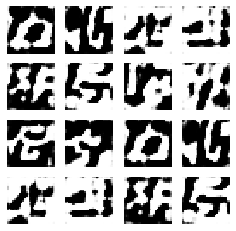

G Train Acc:     0.926 | Loss: 1.535
D Train Acc:     NaN   | Loss: 1.268
D Test Accuracy: 0.584 | Loss: 1.868

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-18


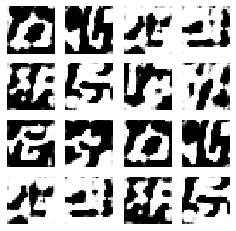

G Train Acc:     0.901 | Loss: 1.560
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.887 | Loss: 1.575



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-27
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-19


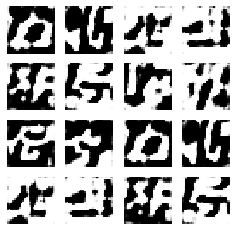

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.887 | Loss: 1.575



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-28
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-20


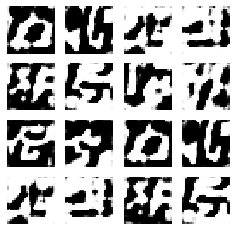

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.887 | Loss: 1.575



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-29
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-21


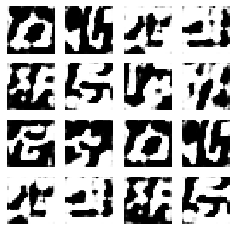

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.887 | Loss: 1.575



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-30
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-22


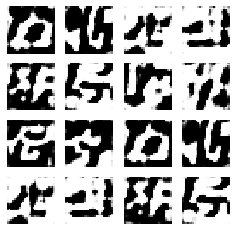

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.887 | Loss: 1.575



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-31
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-23


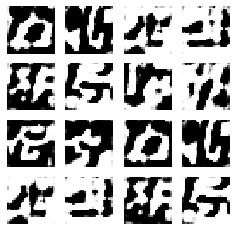

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.887 | Loss: 1.575



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-32
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-24


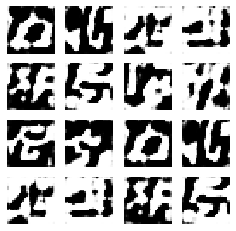

G Train Acc:     0.897 | Loss: 1.564
D Train Acc:     NaN   | Loss: 1.249
D Test Accuracy: 0.887 | Loss: 1.575



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-33
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-25


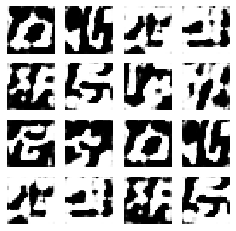

G Train Acc:     0.899 | Loss: 1.562
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.887 | Loss: 1.575



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-34
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-26


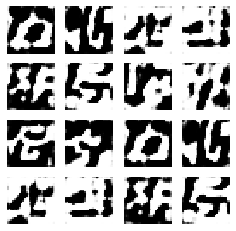

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.887 | Loss: 1.575



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-35
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-27


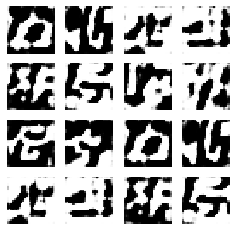

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.887 | Loss: 1.575



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-36
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-28


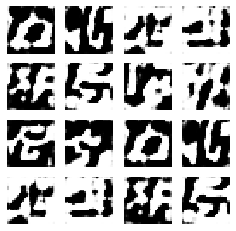

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.887 | Loss: 1.575



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-37
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-29


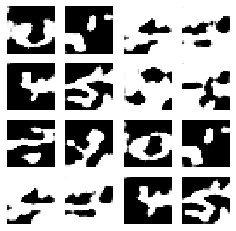

G Train Acc:     0.324 | Loss: 2.138
D Train Acc:     NaN   | Loss: 0.894
D Test Accuracy: 0.096 | Loss: 2.365

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-30


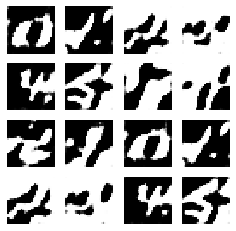

G Train Acc:     0.965 | Loss: 1.496
D Train Acc:     NaN   | Loss: 1.292
D Test Accuracy: 0.331 | Loss: 2.124

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-31


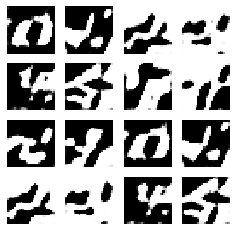

G Train Acc:     0.907 | Loss: 1.554
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.617 | Loss: 1.836

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-32


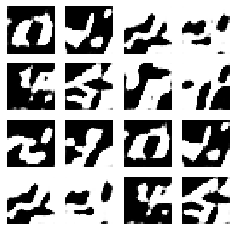

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.580 | Loss: 1.874

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-33


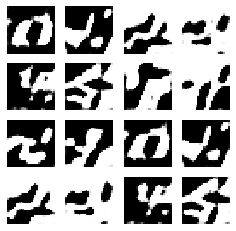

G Train Acc:     0.903 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.590 | Loss: 1.863

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-34


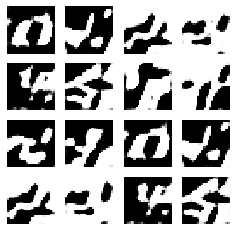

G Train Acc:     0.901 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.511 | Loss: 1.942

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-35


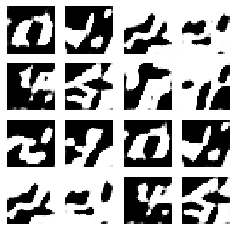

G Train Acc:     0.902 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.625 | Loss: 1.828

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-36


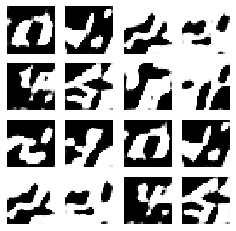

G Train Acc:     0.902 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.577 | Loss: 1.877

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-37


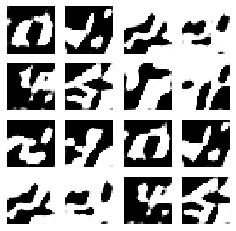

G Train Acc:     0.901 | Loss: 1.560
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.548 | Loss: 1.907

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-38


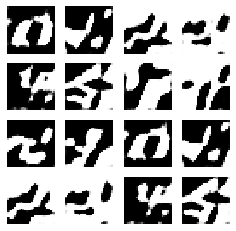

G Train Acc:     0.899 | Loss: 1.562
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.486 | Loss: 1.967

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-39


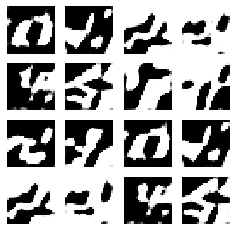

G Train Acc:     0.900 | Loss: 1.562
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.497 | Loss: 1.956

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-40


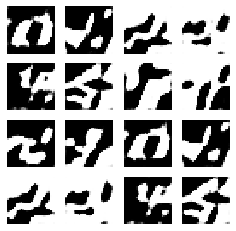

G Train Acc:     0.899 | Loss: 1.562
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.506 | Loss: 1.946

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-41


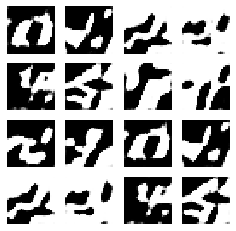

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.579 | Loss: 1.875

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-42


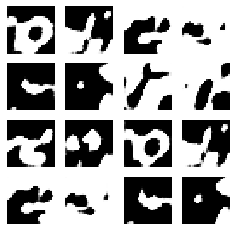

G Train Acc:     0.220 | Loss: 2.241
D Train Acc:     NaN   | Loss: 0.830
D Test Accuracy: 0.101 | Loss: 2.360

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-43


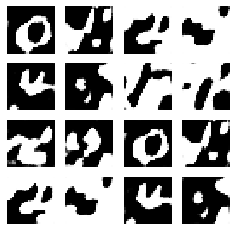

G Train Acc:     0.908 | Loss: 1.553
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.359 | Loss: 2.096

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-44


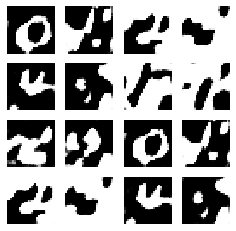

G Train Acc:     0.903 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.805 | Loss: 1.654



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-27
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-45


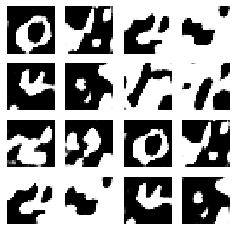

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.805 | Loss: 1.654



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-28
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-46


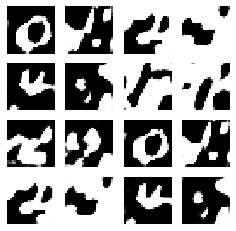

G Train Acc:     0.899 | Loss: 1.563
D Train Acc:     NaN   | Loss: 1.250
D Test Accuracy: 0.805 | Loss: 1.654



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-29
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-47


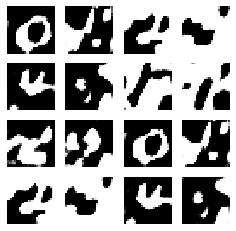

G Train Acc:     0.899 | Loss: 1.563
D Train Acc:     NaN   | Loss: 1.250
D Test Accuracy: 0.805 | Loss: 1.654



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-30
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-48


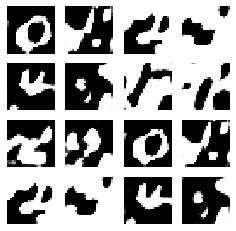

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.805 | Loss: 1.654



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-31
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-49


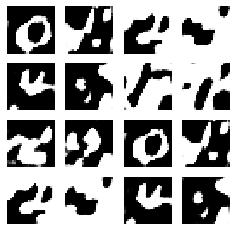

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.805 | Loss: 1.654



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-32
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-50


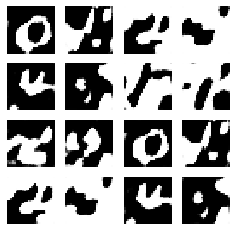

G Train Acc:     0.900 | Loss: 1.562
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.805 | Loss: 1.654



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-33
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-51


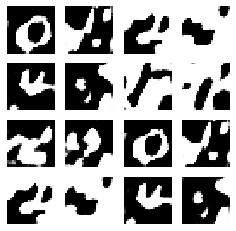

G Train Acc:     0.899 | Loss: 1.562
D Train Acc:     NaN   | Loss: 1.250
D Test Accuracy: 0.805 | Loss: 1.654



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-34
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-52


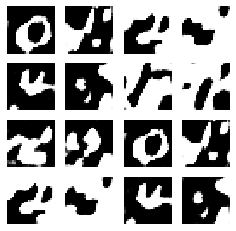

G Train Acc:     0.898 | Loss: 1.563
D Train Acc:     NaN   | Loss: 1.250
D Test Accuracy: 0.805 | Loss: 1.654



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-35
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-53


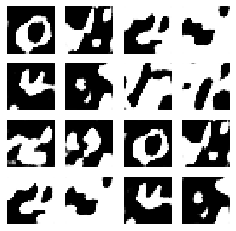

G Train Acc:     0.901 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.805 | Loss: 1.654



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-36
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-54


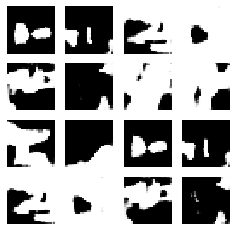

G Train Acc:     0.449 | Loss: 2.012
D Train Acc:     NaN   | Loss: 0.971
D Test Accuracy: 0.098 | Loss: 2.362

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-55


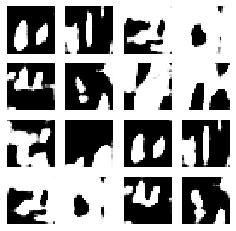

G Train Acc:     0.886 | Loss: 1.576
D Train Acc:     NaN   | Loss: 1.242
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-27
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-56


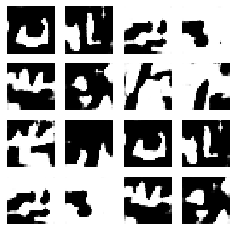

G Train Acc:     0.942 | Loss: 1.520
D Train Acc:     NaN   | Loss: 1.276
D Test Accuracy: 0.549 | Loss: 1.902

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-57


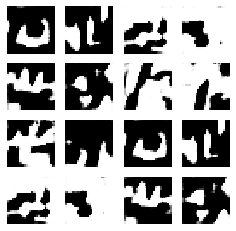

G Train Acc:     0.902 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.446 | Loss: 2.006

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-58


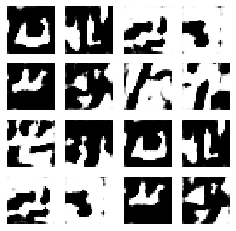

G Train Acc:     0.709 | Loss: 1.752
D Train Acc:     NaN   | Loss: 1.133
D Test Accuracy: 0.307 | Loss: 2.148

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-59


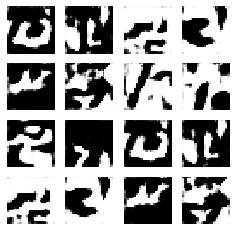

G Train Acc:     0.973 | Loss: 1.488
D Train Acc:     NaN   | Loss: 1.296
D Test Accuracy: 0.817 | Loss: 1.639



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-27
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-60


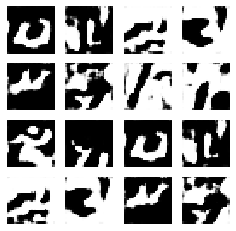

G Train Acc:     0.899 | Loss: 1.562
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.743 | Loss: 1.713

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-61


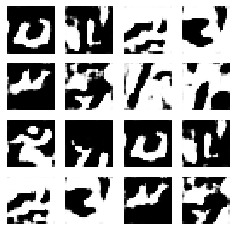

G Train Acc:     0.905 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.804 | Loss: 1.656



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-27
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-62


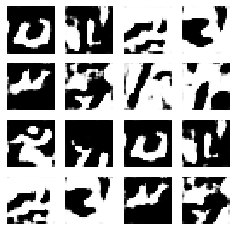

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.804 | Loss: 1.656



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-28
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-63


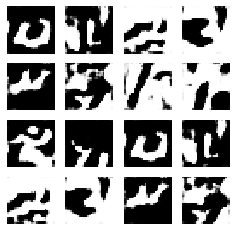

G Train Acc:     0.902 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.804 | Loss: 1.656



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-29
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-64


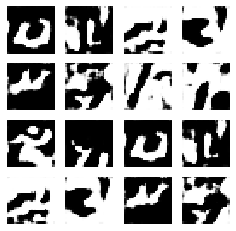

G Train Acc:     0.901 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.804 | Loss: 1.656



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-30
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-65


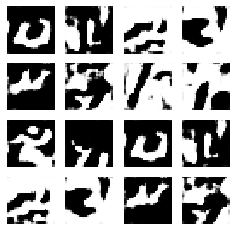

G Train Acc:     0.901 | Loss: 1.560
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.804 | Loss: 1.656



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-31
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-66


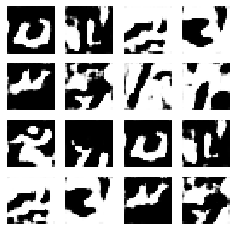

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.804 | Loss: 1.656



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-32
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-67


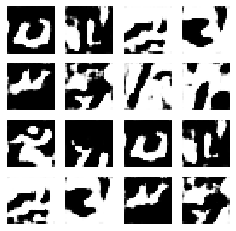

G Train Acc:     0.902 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.804 | Loss: 1.656



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-33
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-68


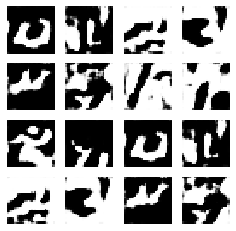

G Train Acc:     0.901 | Loss: 1.560
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.804 | Loss: 1.656



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-34
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-69


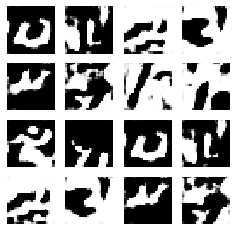

G Train Acc:     0.899 | Loss: 1.562
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.804 | Loss: 1.656



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-35
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-70


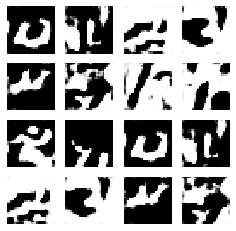

G Train Acc:     0.899 | Loss: 1.563
D Train Acc:     NaN   | Loss: 1.250
D Test Accuracy: 0.804 | Loss: 1.656



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-36
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-71


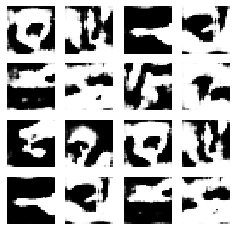

G Train Acc:     0.426 | Loss: 2.035
D Train Acc:     NaN   | Loss: 0.957
D Test Accuracy: 0.101 | Loss: 2.360

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-72


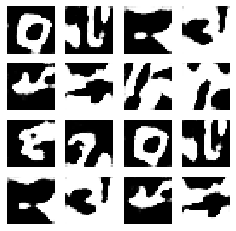

G Train Acc:     0.928 | Loss: 1.533
D Train Acc:     NaN   | Loss: 1.269
D Test Accuracy: 0.305 | Loss: 2.148

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-73


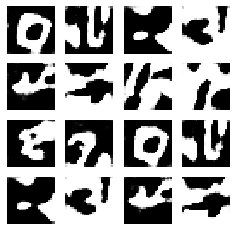

G Train Acc:     0.823 | Loss: 1.638
D Train Acc:     NaN   | Loss: 1.203
D Test Accuracy: 0.277 | Loss: 2.180

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-74


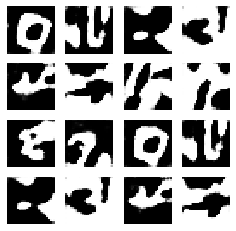

G Train Acc:     0.729 | Loss: 1.732
D Train Acc:     NaN   | Loss: 1.145
D Test Accuracy: 0.298 | Loss: 2.154

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-75


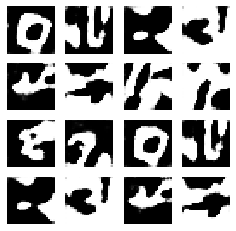

G Train Acc:     0.814 | Loss: 1.647
D Train Acc:     NaN   | Loss: 1.198
D Test Accuracy: 0.340 | Loss: 2.114

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-76


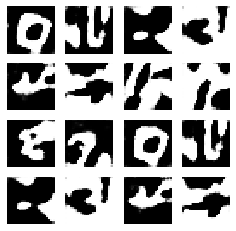

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.452 | Loss: 2.003

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-77


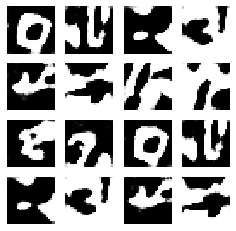

G Train Acc:     0.904 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.499 | Loss: 1.956

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-78


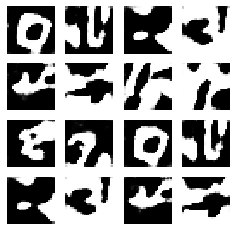

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.303 | Loss: 2.152

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-79


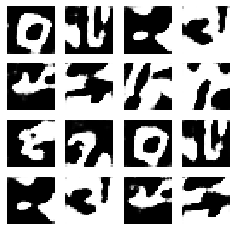

G Train Acc:     0.907 | Loss: 1.554
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.313 | Loss: 2.141

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-80


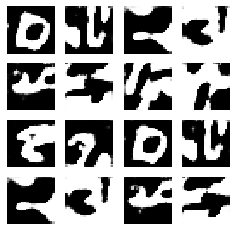

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.258 | Loss: 2.197

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-81


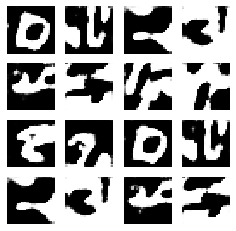

G Train Acc:     0.907 | Loss: 1.554
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.276 | Loss: 2.180

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-82


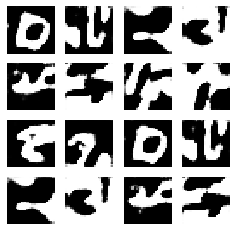

G Train Acc:     0.817 | Loss: 1.644
D Train Acc:     NaN   | Loss: 1.200
D Test Accuracy: 0.248 | Loss: 2.208

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-83


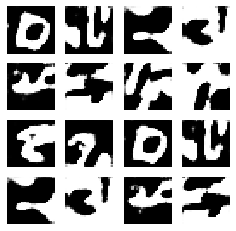

G Train Acc:     0.906 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.303 | Loss: 2.152

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-84


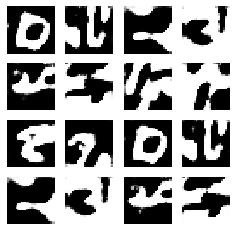

G Train Acc:     0.904 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.381 | Loss: 2.073

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-85


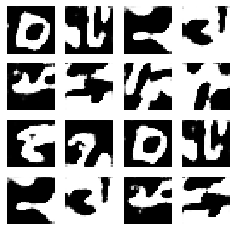

G Train Acc:     0.908 | Loss: 1.553
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.307 | Loss: 2.147

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-86


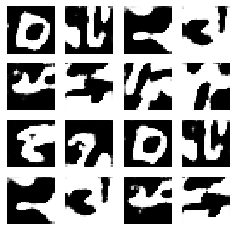

G Train Acc:     0.902 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.315 | Loss: 2.139

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-87


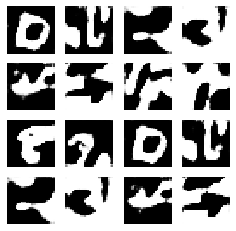

G Train Acc:     0.908 | Loss: 1.554
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.396 | Loss: 2.058

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-88


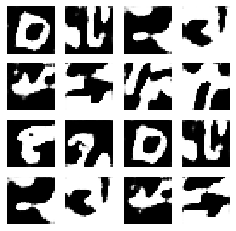

G Train Acc:     0.815 | Loss: 1.646
D Train Acc:     NaN   | Loss: 1.199
D Test Accuracy: 0.244 | Loss: 2.213

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-89


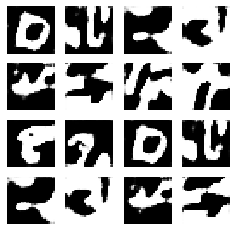

G Train Acc:     0.908 | Loss: 1.553
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.359 | Loss: 2.095

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-90


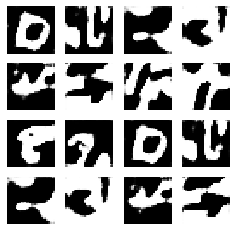

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.394 | Loss: 2.059

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-91


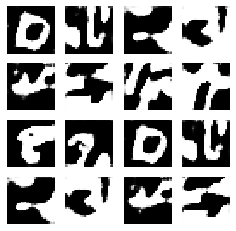

G Train Acc:     0.821 | Loss: 1.640
D Train Acc:     NaN   | Loss: 1.203
D Test Accuracy: 0.202 | Loss: 2.257

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-92


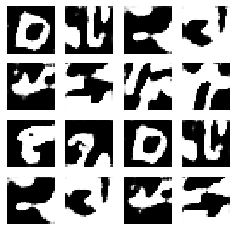

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.331 | Loss: 2.123

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-93


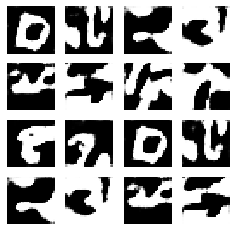

G Train Acc:     0.907 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.239 | Loss: 2.219

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-94


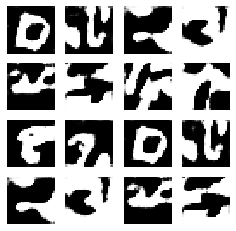

G Train Acc:     0.904 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.456 | Loss: 1.999

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-95


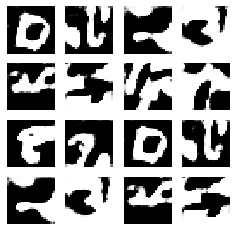

G Train Acc:     0.912 | Loss: 1.549
D Train Acc:     NaN   | Loss: 1.259
D Test Accuracy: 0.256 | Loss: 2.200

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-96


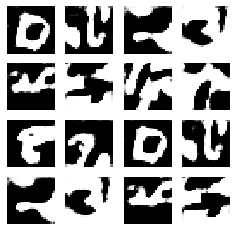

G Train Acc:     0.909 | Loss: 1.552
D Train Acc:     NaN   | Loss: 1.257
D Test Accuracy: 0.262 | Loss: 2.194

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-97


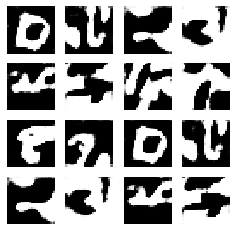

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.382 | Loss: 2.072

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-98


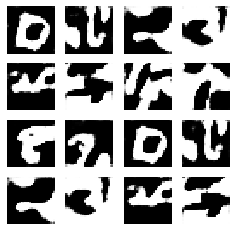

G Train Acc:     0.904 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.391 | Loss: 2.063

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-99


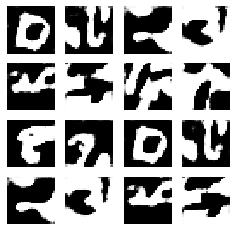

G Train Acc:     0.905 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.285 | Loss: 2.171

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-100


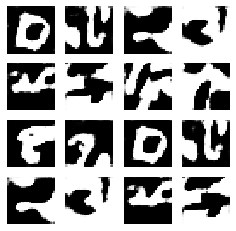

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.247 | Loss: 2.210

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-101


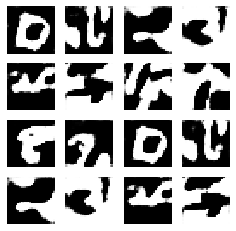

G Train Acc:     0.905 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.390 | Loss: 2.064

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-102


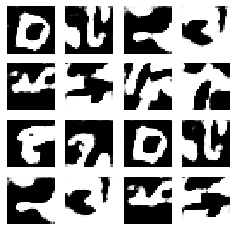

G Train Acc:     0.905 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.418 | Loss: 2.036

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-103


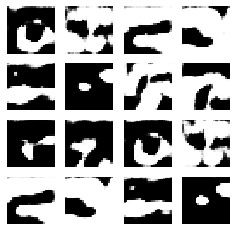

G Train Acc:     0.354 | Loss: 2.107
D Train Acc:     NaN   | Loss: 0.913
D Test Accuracy: 0.103 | Loss: 2.357

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-104


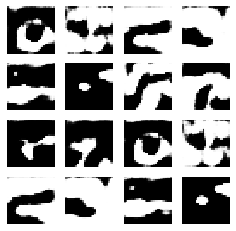

G Train Acc:     0.801 | Loss: 1.660
D Train Acc:     NaN   | Loss: 1.190
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-27
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-105


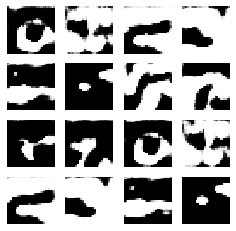

G Train Acc:     0.799 | Loss: 1.662
D Train Acc:     NaN   | Loss: 1.189
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-28
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-106


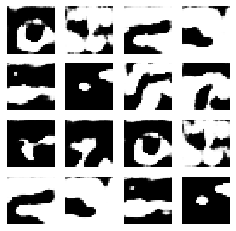

G Train Acc:     0.800 | Loss: 1.662
D Train Acc:     NaN   | Loss: 1.189
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-29
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-107


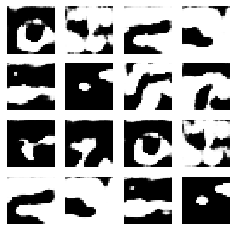

G Train Acc:     0.800 | Loss: 1.662
D Train Acc:     NaN   | Loss: 1.189
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-30
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-108


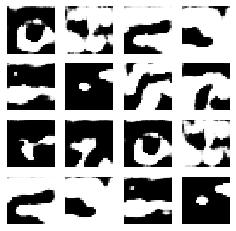

G Train Acc:     0.804 | Loss: 1.657
D Train Acc:     NaN   | Loss: 1.192
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-31
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-109


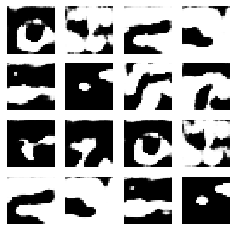

G Train Acc:     0.803 | Loss: 1.658
D Train Acc:     NaN   | Loss: 1.191
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-32
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-110


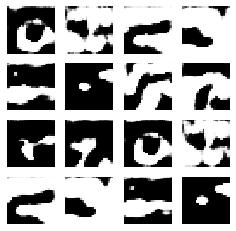

G Train Acc:     0.799 | Loss: 1.662
D Train Acc:     NaN   | Loss: 1.189
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-33
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-111


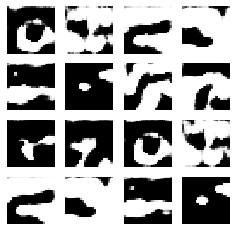

G Train Acc:     0.799 | Loss: 1.663
D Train Acc:     NaN   | Loss: 1.188
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-34
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-112


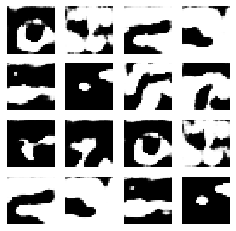

G Train Acc:     0.798 | Loss: 1.664
D Train Acc:     NaN   | Loss: 1.188
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-35
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-113


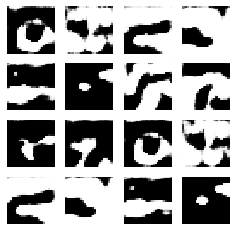

G Train Acc:     0.799 | Loss: 1.662
D Train Acc:     NaN   | Loss: 1.189
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-36
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-114


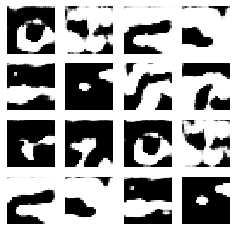

G Train Acc:     0.803 | Loss: 1.659
D Train Acc:     NaN   | Loss: 1.191
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-37
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-115


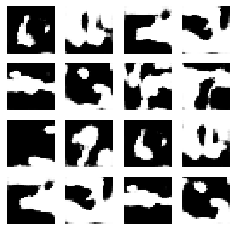

G Train Acc:     0.354 | Loss: 2.107
D Train Acc:     NaN   | Loss: 0.912
D Test Accuracy: 0.089 | Loss: 2.371

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-116


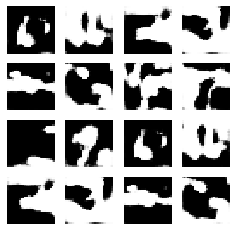

G Train Acc:     0.702 | Loss: 1.759
D Train Acc:     NaN   | Loss: 1.128
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-27
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-117


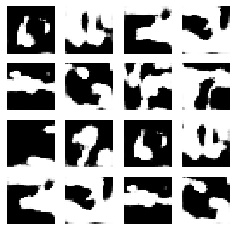

G Train Acc:     0.701 | Loss: 1.760
D Train Acc:     NaN   | Loss: 1.128
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-28
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-118


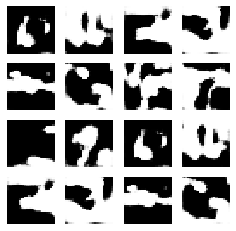

G Train Acc:     0.700 | Loss: 1.761
D Train Acc:     NaN   | Loss: 1.127
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-29
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-119


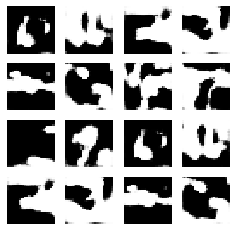

G Train Acc:     0.699 | Loss: 1.762
D Train Acc:     NaN   | Loss: 1.127
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-30
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-120


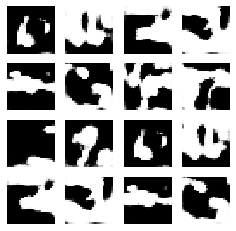

G Train Acc:     0.702 | Loss: 1.759
D Train Acc:     NaN   | Loss: 1.128
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-31
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-121


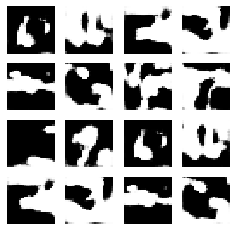

G Train Acc:     0.700 | Loss: 1.761
D Train Acc:     NaN   | Loss: 1.127
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-32
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-122


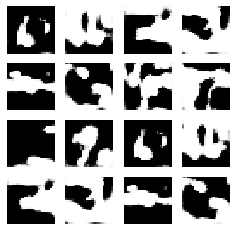

G Train Acc:     0.700 | Loss: 1.761
D Train Acc:     NaN   | Loss: 1.127
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-33
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-123


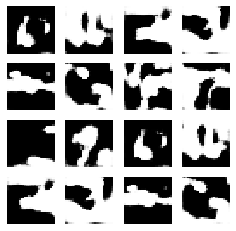

G Train Acc:     0.697 | Loss: 1.764
D Train Acc:     NaN   | Loss: 1.126
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-34
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-124


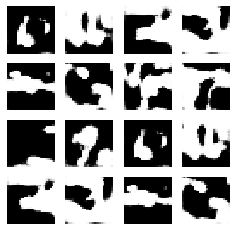

G Train Acc:     0.697 | Loss: 1.764
D Train Acc:     NaN   | Loss: 1.125
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-35
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-125


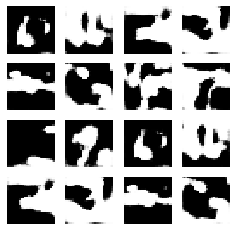

G Train Acc:     0.703 | Loss: 1.759
D Train Acc:     NaN   | Loss: 1.129
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-36
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-126


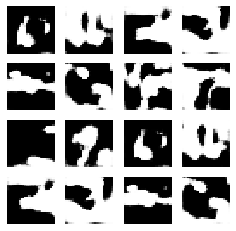

G Train Acc:     0.700 | Loss: 1.761
D Train Acc:     NaN   | Loss: 1.127
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-37
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-127


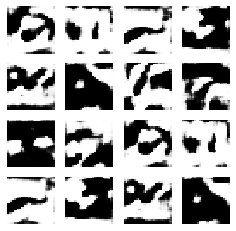

G Train Acc:     0.336 | Loss: 2.126
D Train Acc:     NaN   | Loss: 0.901
D Test Accuracy: 0.096 | Loss: 2.365

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-128


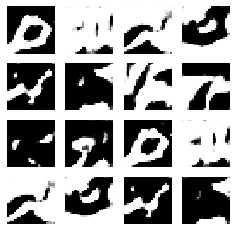

G Train Acc:     0.823 | Loss: 1.639
D Train Acc:     NaN   | Loss: 1.203
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-27
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-129


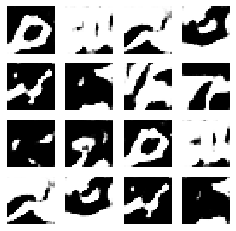

G Train Acc:     0.901 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-28
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-130


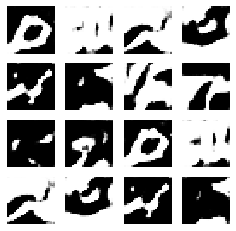

G Train Acc:     0.901 | Loss: 1.560
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-29
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-131


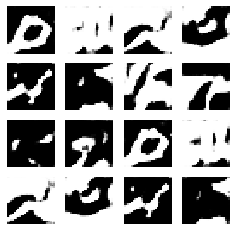

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-30
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-132


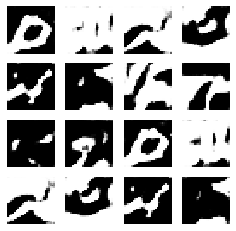

G Train Acc:     0.901 | Loss: 1.560
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-31
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-133


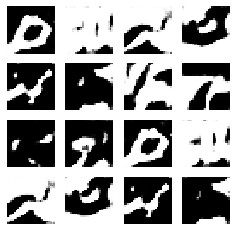

G Train Acc:     0.898 | Loss: 1.563
D Train Acc:     NaN   | Loss: 1.250
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-32
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-134


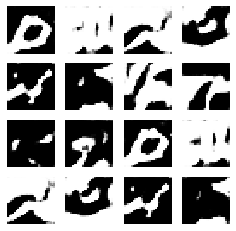

G Train Acc:     0.899 | Loss: 1.562
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-33
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-135


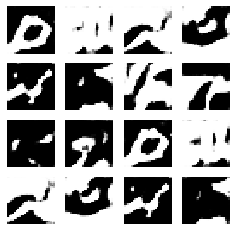

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-34
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-136


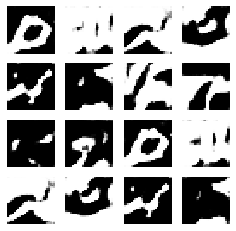

G Train Acc:     0.898 | Loss: 1.563
D Train Acc:     NaN   | Loss: 1.250
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-35
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-137


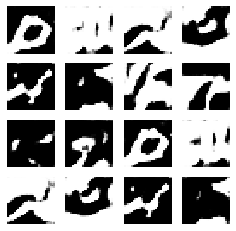

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-36
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-138


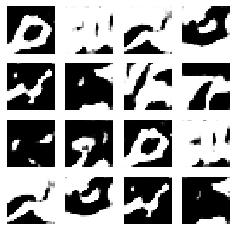

G Train Acc:     0.898 | Loss: 1.563
D Train Acc:     NaN   | Loss: 1.250
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-37
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-139


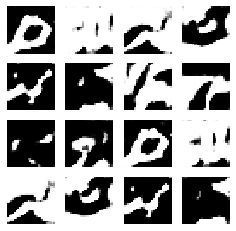

G Train Acc:     0.899 | Loss: 1.563
D Train Acc:     NaN   | Loss: 1.250
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-38
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-140


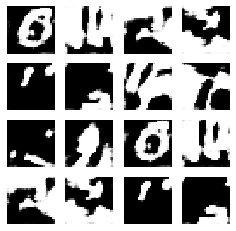

G Train Acc:     0.505 | Loss: 1.956
D Train Acc:     NaN   | Loss: 1.006
D Test Accuracy: 0.103 | Loss: 2.359

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-141


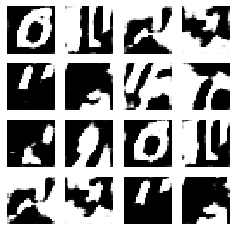

G Train Acc:     0.918 | Loss: 1.543
D Train Acc:     NaN   | Loss: 1.263
D Test Accuracy: 0.657 | Loss: 1.796

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-142


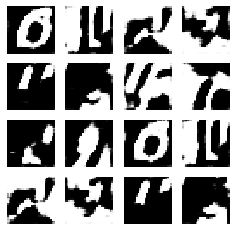

G Train Acc:     0.904 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.695 | Loss: 1.762

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-143


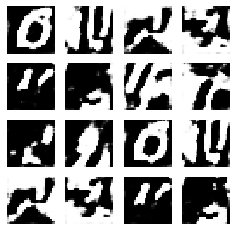

G Train Acc:     0.915 | Loss: 1.547
D Train Acc:     NaN   | Loss: 1.260
D Test Accuracy: 0.540 | Loss: 1.916

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-144


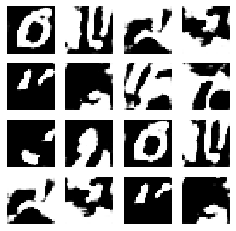

G Train Acc:     0.964 | Loss: 1.497
D Train Acc:     NaN   | Loss: 1.291
D Test Accuracy: 0.914 | Loss: 1.548



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-27
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-145


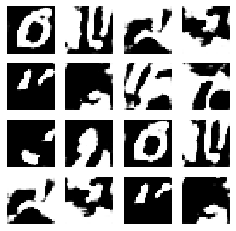

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.883 | Loss: 1.575



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-28
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-146


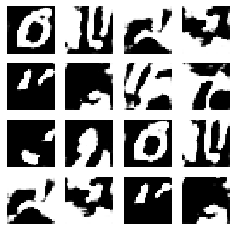

G Train Acc:     0.899 | Loss: 1.562
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.883 | Loss: 1.575



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-29
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-147


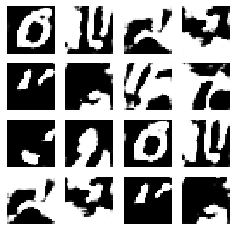

G Train Acc:     0.899 | Loss: 1.562
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.883 | Loss: 1.575



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-30
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-148


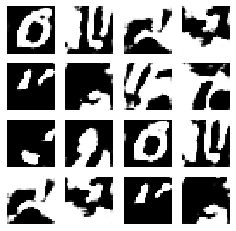

G Train Acc:     0.899 | Loss: 1.562
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.883 | Loss: 1.575



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-31
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-149


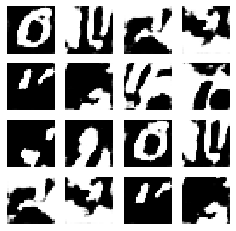

G Train Acc:     0.963 | Loss: 1.498
D Train Acc:     NaN   | Loss: 1.290
D Test Accuracy: 0.883 | Loss: 1.575



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-32
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-150


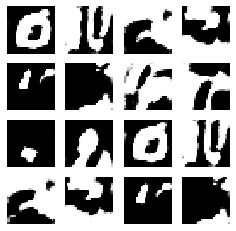

G Train Acc:     0.916 | Loss: 1.546
D Train Acc:     NaN   | Loss: 1.260
D Test Accuracy: 0.544 | Loss: 1.910

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-151


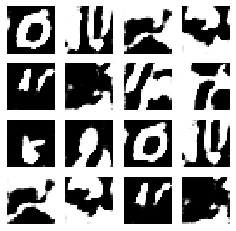

G Train Acc:     0.968 | Loss: 1.494
D Train Acc:     NaN   | Loss: 1.293
D Test Accuracy: 0.272 | Loss: 2.185

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-152


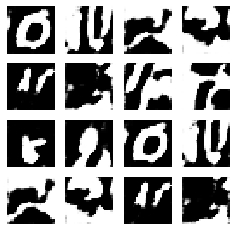

G Train Acc:     0.905 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.552 | Loss: 1.904

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-153


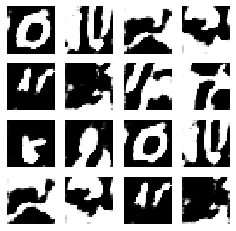

G Train Acc:     0.812 | Loss: 1.649
D Train Acc:     NaN   | Loss: 1.197
D Test Accuracy: 0.684 | Loss: 1.770

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-154


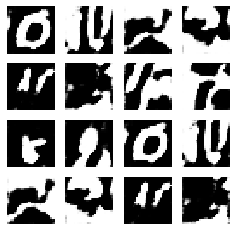

G Train Acc:     0.910 | Loss: 1.551
D Train Acc:     NaN   | Loss: 1.258
D Test Accuracy: 0.509 | Loss: 1.947

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-155


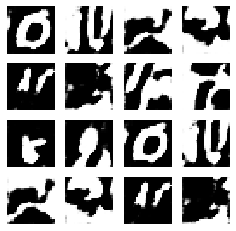

G Train Acc:     0.908 | Loss: 1.554
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.481 | Loss: 1.974

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-156


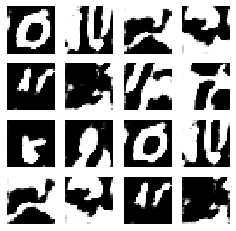

G Train Acc:     0.907 | Loss: 1.554
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.744 | Loss: 1.713

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-157


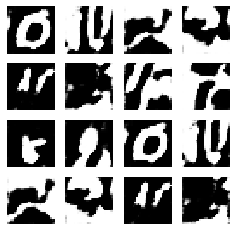

G Train Acc:     0.907 | Loss: 1.554
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.600 | Loss: 1.854

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-158


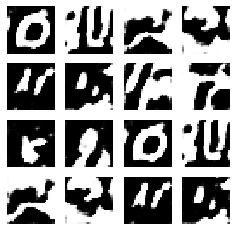

G Train Acc:     0.888 | Loss: 1.573
D Train Acc:     NaN   | Loss: 1.244
D Test Accuracy: 0.660 | Loss: 1.795

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-159


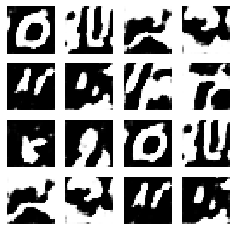

G Train Acc:     0.902 | Loss: 1.560
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.572 | Loss: 1.881

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-160


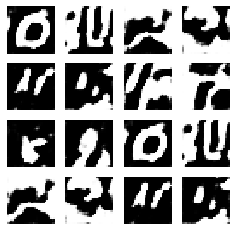

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.605 | Loss: 1.849

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-161


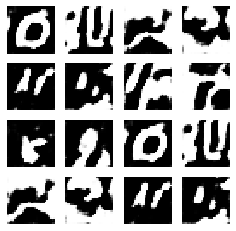

G Train Acc:     0.901 | Loss: 1.560
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.592 | Loss: 1.862

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-162


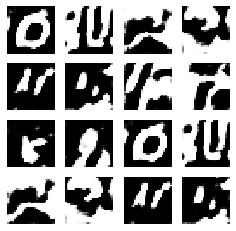

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.620 | Loss: 1.834

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-163


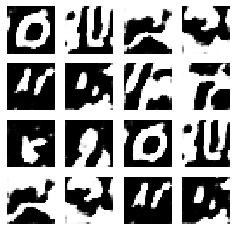

G Train Acc:     0.904 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.601 | Loss: 1.852

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-164


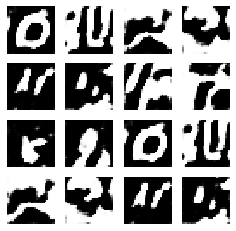

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.604 | Loss: 1.849

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-165


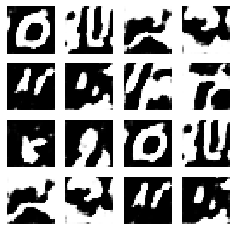

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.615 | Loss: 1.839

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-166


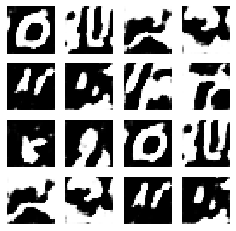

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.592 | Loss: 1.861

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-167


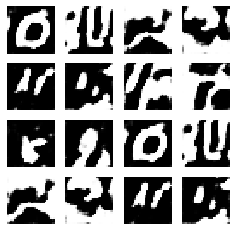

G Train Acc:     0.902 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.600 | Loss: 1.854

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-168


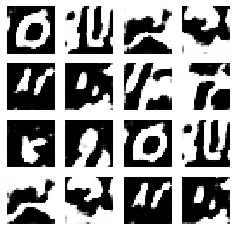

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.553 | Loss: 1.902

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-169


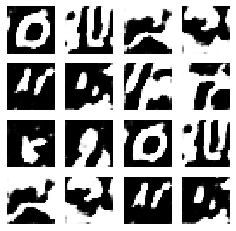

G Train Acc:     0.903 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.583 | Loss: 1.871

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-170


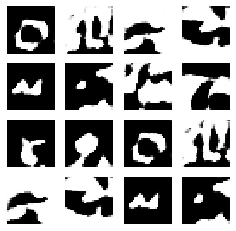

G Train Acc:     0.567 | Loss: 1.894
D Train Acc:     NaN   | Loss: 1.045
D Test Accuracy: 0.096 | Loss: 2.365

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-171


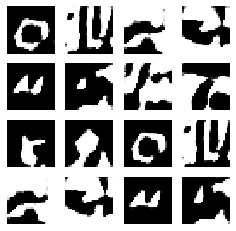

G Train Acc:     0.925 | Loss: 1.537
D Train Acc:     NaN   | Loss: 1.266
D Test Accuracy: 0.563 | Loss: 1.887

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-172


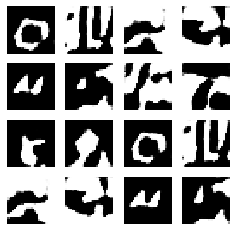

G Train Acc:     0.904 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.544 | Loss: 1.907

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-173


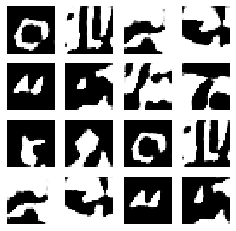

G Train Acc:     0.905 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.553 | Loss: 1.896

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-174


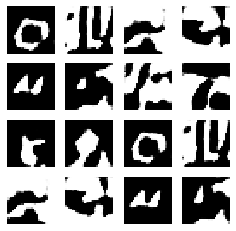

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.557 | Loss: 1.893

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-175


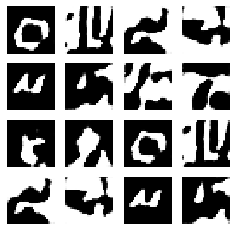

G Train Acc:     0.904 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.527 | Loss: 1.925

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-176


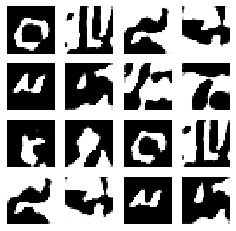

G Train Acc:     0.907 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.380 | Loss: 2.073

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-177


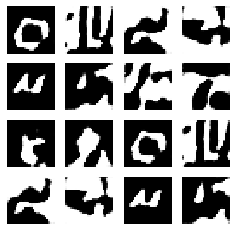

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.501 | Loss: 1.954

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-178


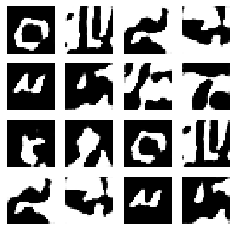

G Train Acc:     0.905 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.475 | Loss: 1.980

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-179


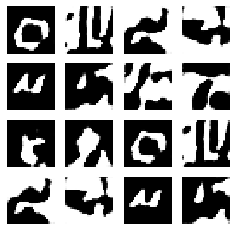

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.477 | Loss: 1.980

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-180


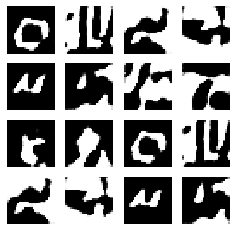

G Train Acc:     0.907 | Loss: 1.554
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.445 | Loss: 2.010

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-181


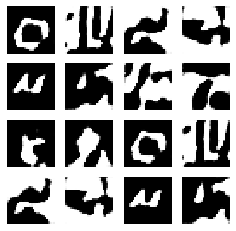

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.479 | Loss: 1.976

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-182


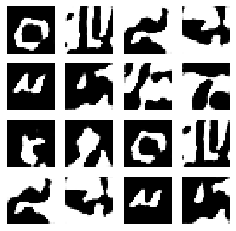

G Train Acc:     0.909 | Loss: 1.553
D Train Acc:     NaN   | Loss: 1.257
D Test Accuracy: 0.581 | Loss: 1.869

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-183


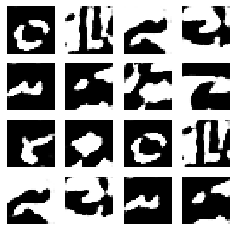

G Train Acc:     0.392 | Loss: 2.070
D Train Acc:     NaN   | Loss: 0.936
D Test Accuracy: 0.103 | Loss: 2.357

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-184


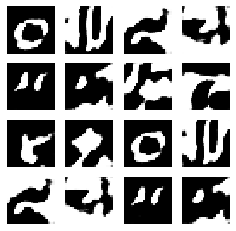

G Train Acc:     0.925 | Loss: 1.536
D Train Acc:     NaN   | Loss: 1.267
D Test Accuracy: 0.366 | Loss: 2.088

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-185


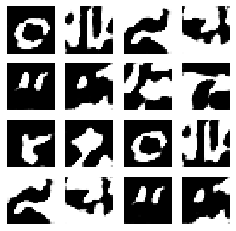

G Train Acc:     0.948 | Loss: 1.513
D Train Acc:     NaN   | Loss: 1.281
D Test Accuracy: 0.643 | Loss: 1.812

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-186


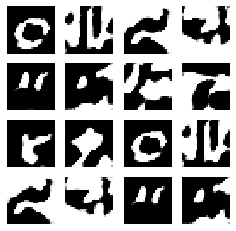

G Train Acc:     0.907 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.589 | Loss: 1.866

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-187


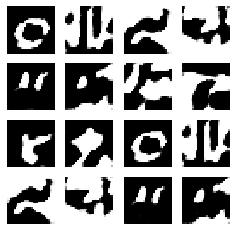

G Train Acc:     0.904 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.580 | Loss: 1.876

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-188


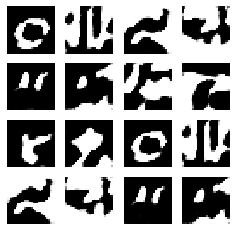

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.425 | Loss: 2.029

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-189


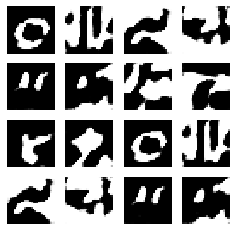

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.597 | Loss: 1.858

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-190


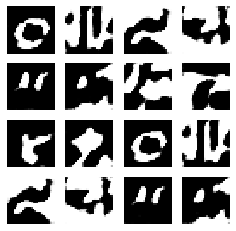

G Train Acc:     0.907 | Loss: 1.554
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.594 | Loss: 1.862

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-191


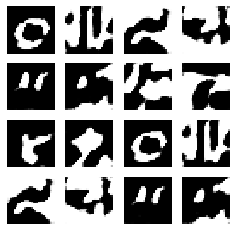

G Train Acc:     0.905 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.552 | Loss: 1.905

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-192


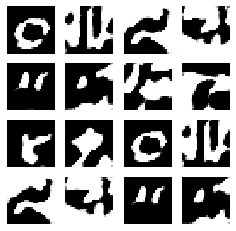

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.557 | Loss: 1.898

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-193


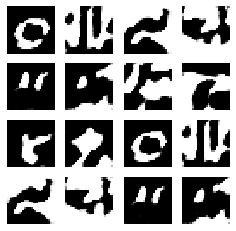

G Train Acc:     0.905 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.533 | Loss: 1.923

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-194


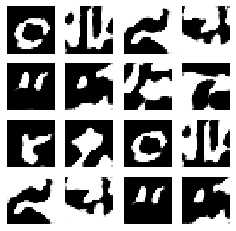

G Train Acc:     0.908 | Loss: 1.553
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.543 | Loss: 1.914

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-195


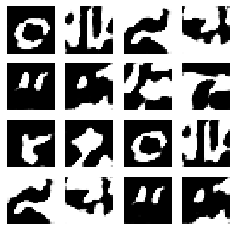

G Train Acc:     0.904 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.623 | Loss: 1.831

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-196


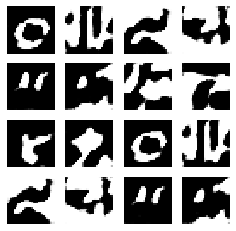

G Train Acc:     0.907 | Loss: 1.554
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.590 | Loss: 1.864

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-197


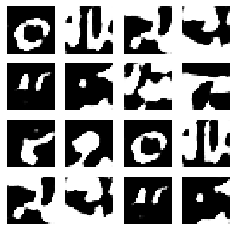

G Train Acc:     0.483 | Loss: 1.978
D Train Acc:     NaN   | Loss: 0.992
D Test Accuracy: 0.096 | Loss: 2.365

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-198


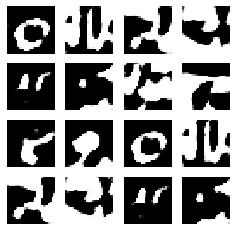

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.395 | Loss: 2.058

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-199


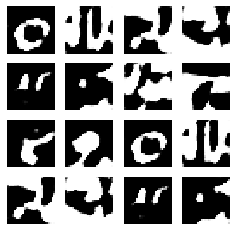

G Train Acc:     0.904 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.563 | Loss: 1.891

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-200


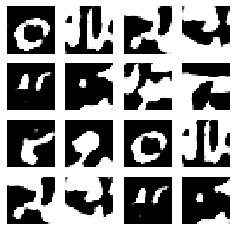

G Train Acc:     0.907 | Loss: 1.554
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.277 | Loss: 2.180

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-201


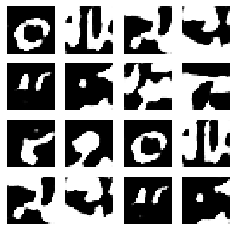

G Train Acc:     0.908 | Loss: 1.553
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.711 | Loss: 1.744

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-202


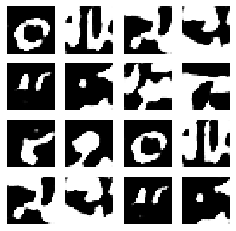

G Train Acc:     0.905 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.601 | Loss: 1.853

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-203


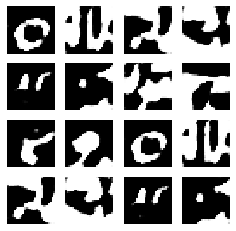

G Train Acc:     0.903 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.583 | Loss: 1.873

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-204


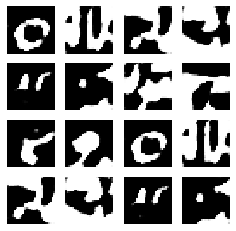

G Train Acc:     0.907 | Loss: 1.554
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.356 | Loss: 2.098

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-205


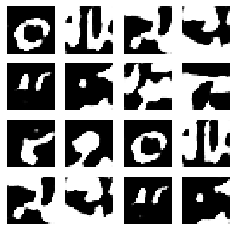

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.380 | Loss: 2.073

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-206


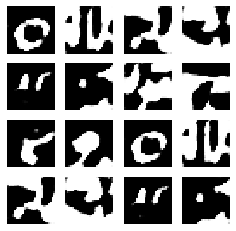

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.530 | Loss: 1.925

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-207


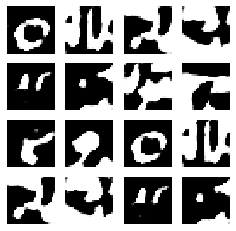

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.710 | Loss: 1.746

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-208


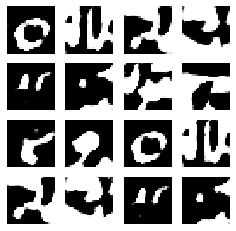

G Train Acc:     0.904 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.431 | Loss: 2.023

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-209


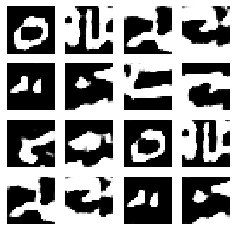

G Train Acc:     0.587 | Loss: 1.874
D Train Acc:     NaN   | Loss: 1.057
D Test Accuracy: 0.097 | Loss: 2.365

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-210


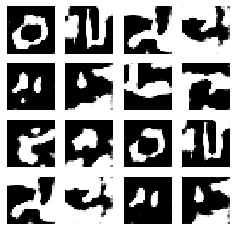

G Train Acc:     0.970 | Loss: 1.492
D Train Acc:     NaN   | Loss: 1.294
D Test Accuracy: 0.311 | Loss: 2.144

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-211


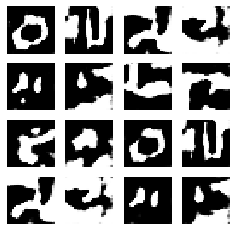

G Train Acc:     0.901 | Loss: 1.560
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.723 | Loss: 1.733

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-212


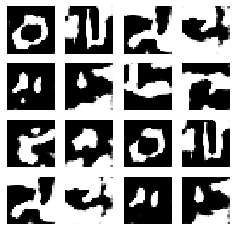

G Train Acc:     0.902 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.702 | Loss: 1.753

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-213


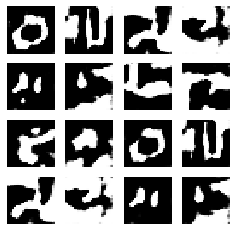

G Train Acc:     0.904 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.738 | Loss: 1.718

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-214


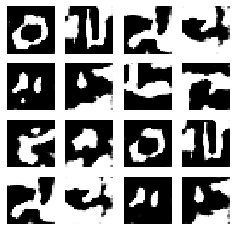

G Train Acc:     0.902 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.739 | Loss: 1.717

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-215


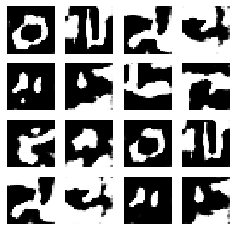

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.706 | Loss: 1.750

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-216


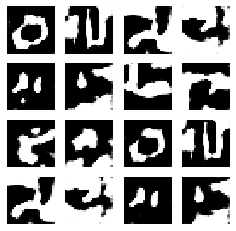

G Train Acc:     0.901 | Loss: 1.560
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.691 | Loss: 1.763

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-217


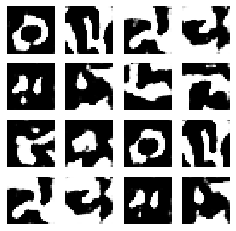

G Train Acc:     0.976 | Loss: 1.486
D Train Acc:     NaN   | Loss: 1.298
D Test Accuracy: 0.666 | Loss: 1.788

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-218


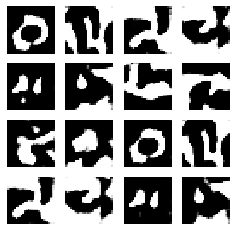

G Train Acc:     0.904 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.489 | Loss: 1.964

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-219


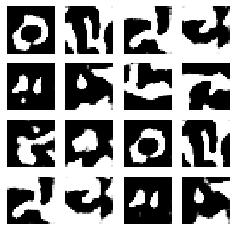

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.532 | Loss: 1.922

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-220


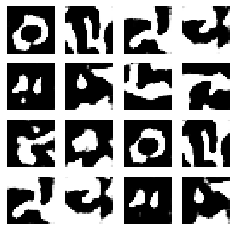

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.481 | Loss: 1.973

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-221


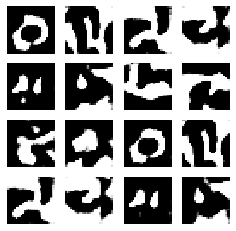

G Train Acc:     0.904 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.399 | Loss: 2.054

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-222


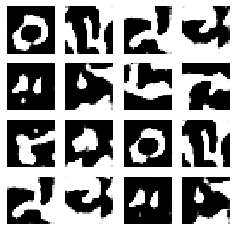

G Train Acc:     0.907 | Loss: 1.554
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.350 | Loss: 2.105

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-223


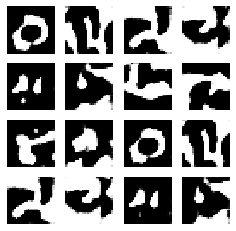

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.541 | Loss: 1.913

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-224


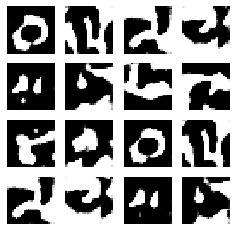

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.442 | Loss: 2.011

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-225


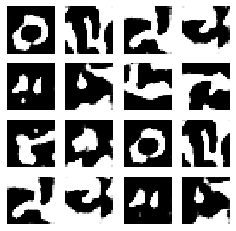

G Train Acc:     0.909 | Loss: 1.552
D Train Acc:     NaN   | Loss: 1.257
D Test Accuracy: 0.439 | Loss: 2.012

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-226


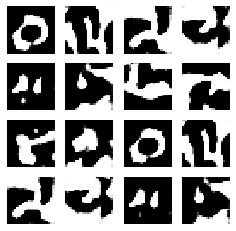

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.541 | Loss: 1.911

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-227


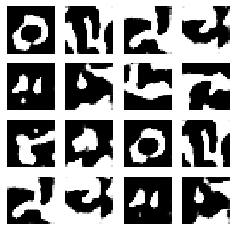

G Train Acc:     0.901 | Loss: 1.560
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.505 | Loss: 1.950

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-228


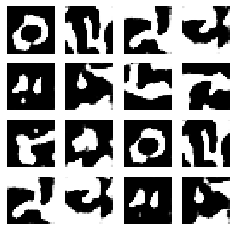

G Train Acc:     0.904 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.471 | Loss: 1.982

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-229


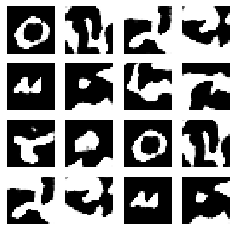

G Train Acc:     0.488 | Loss: 1.973
D Train Acc:     NaN   | Loss: 0.996
D Test Accuracy: 0.103 | Loss: 2.357

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-230


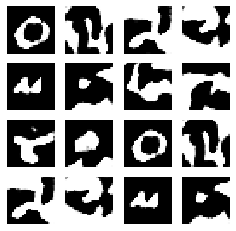

G Train Acc:     0.902 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.469 | Loss: 1.985

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-231


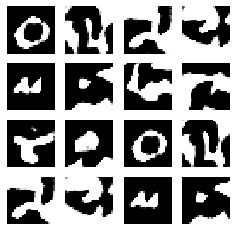

G Train Acc:     0.904 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.483 | Loss: 1.972

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-232


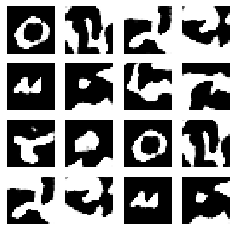

G Train Acc:     0.902 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.554 | Loss: 1.900

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-233


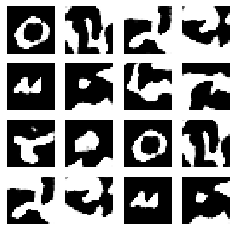

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.492 | Loss: 1.960

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-234


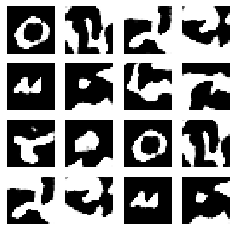

G Train Acc:     0.902 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.519 | Loss: 1.934

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-235


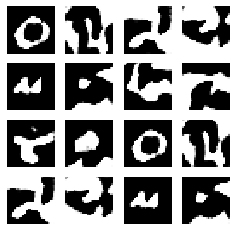

G Train Acc:     0.904 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.491 | Loss: 1.961

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-236


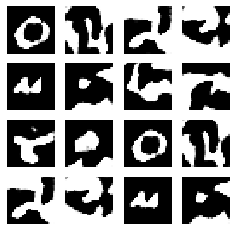

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.528 | Loss: 1.924

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-237


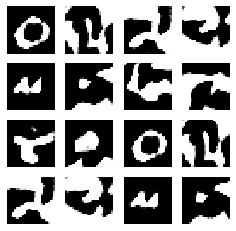

G Train Acc:     0.904 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.498 | Loss: 1.954

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-238


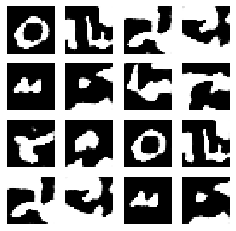

G Train Acc:     0.937 | Loss: 1.525
D Train Acc:     NaN   | Loss: 1.274
D Test Accuracy: 0.661 | Loss: 1.792

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-239


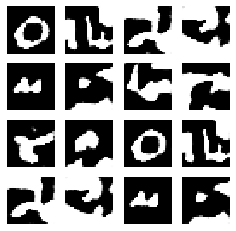

G Train Acc:     0.908 | Loss: 1.553
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.368 | Loss: 2.088

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-240


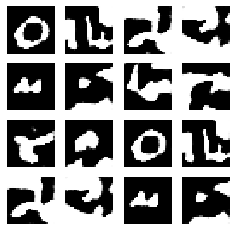

G Train Acc:     0.905 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.433 | Loss: 2.022

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-241


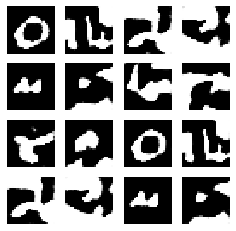

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.340 | Loss: 2.114

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-242


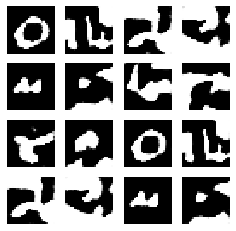

G Train Acc:     0.904 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.423 | Loss: 2.030

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-243


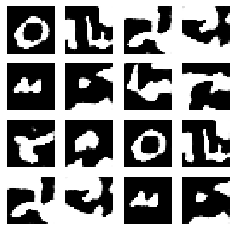

G Train Acc:     0.906 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.416 | Loss: 2.037

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-244


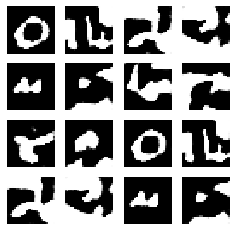

G Train Acc:     0.905 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.464 | Loss: 1.990

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-245


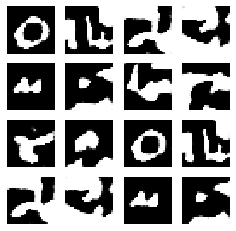

G Train Acc:     0.905 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.330 | Loss: 2.126

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-246


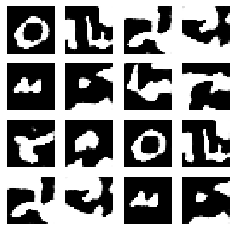

G Train Acc:     0.906 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.416 | Loss: 2.036

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-247


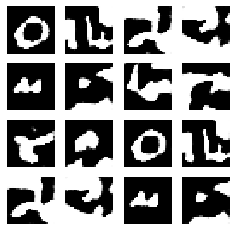

G Train Acc:     0.904 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.359 | Loss: 2.093

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-248


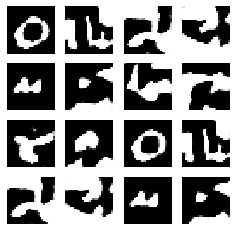

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.409 | Loss: 2.045

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-249


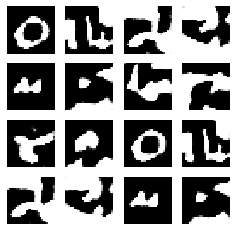

G Train Acc:     0.904 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.404 | Loss: 2.049

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-250


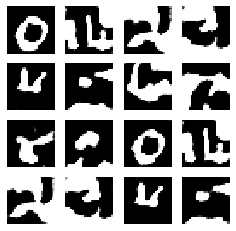

G Train Acc:     0.334 | Loss: 2.127
D Train Acc:     NaN   | Loss: 0.900
D Test Accuracy: 0.103 | Loss: 2.357

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-251


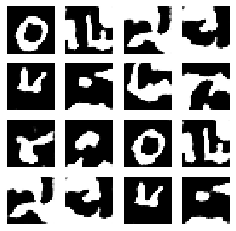

G Train Acc:     0.908 | Loss: 1.554
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.416 | Loss: 2.038

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-252


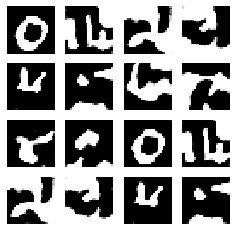

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.375 | Loss: 2.081

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-253


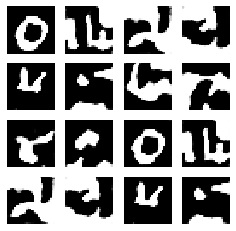

G Train Acc:     0.905 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.339 | Loss: 2.115

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-254


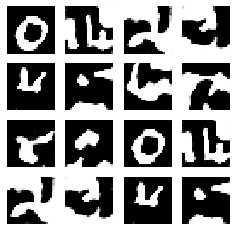

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.496 | Loss: 1.960

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-255


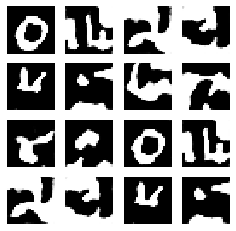

G Train Acc:     0.904 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.379 | Loss: 2.075

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-256


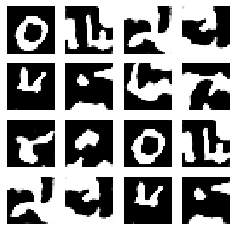

G Train Acc:     0.911 | Loss: 1.550
D Train Acc:     NaN   | Loss: 1.258
D Test Accuracy: 0.335 | Loss: 2.119

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-257


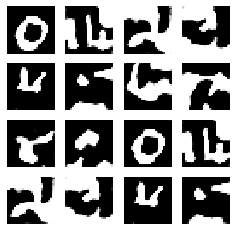

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.365 | Loss: 2.090

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-258


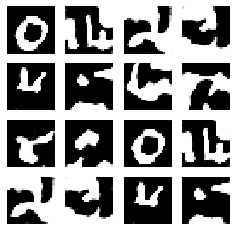

G Train Acc:     0.906 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.352 | Loss: 2.104

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-259


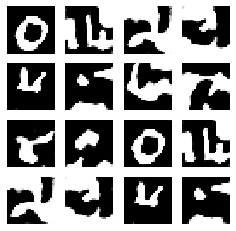

G Train Acc:     0.907 | Loss: 1.555
D Train Acc:     NaN   | Loss: 1.255
D Test Accuracy: 0.403 | Loss: 2.049

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-260


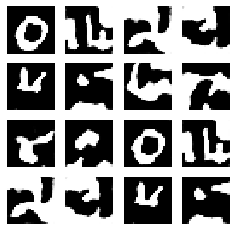

G Train Acc:     0.904 | Loss: 1.557
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.439 | Loss: 2.014

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-261


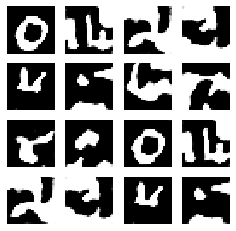

G Train Acc:     0.907 | Loss: 1.554
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.389 | Loss: 2.064

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-262


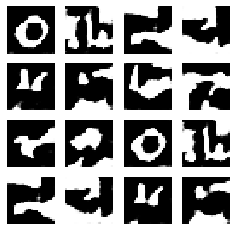

G Train Acc:     0.478 | Loss: 1.983
D Train Acc:     NaN   | Loss: 0.990
D Test Accuracy: 0.101 | Loss: 2.360

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-263


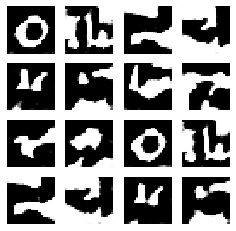

G Train Acc:     0.905 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.780 | Loss: 1.676



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-27
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-264


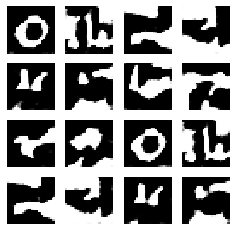

G Train Acc:     0.898 | Loss: 1.563
D Train Acc:     NaN   | Loss: 1.250
D Test Accuracy: 0.780 | Loss: 1.676



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-28
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-265


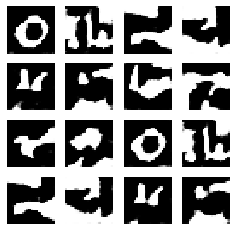

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.780 | Loss: 1.676



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-29
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-266


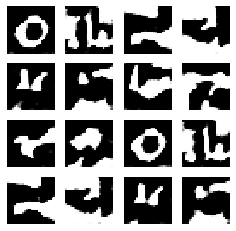

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.780 | Loss: 1.676



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-30
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-267


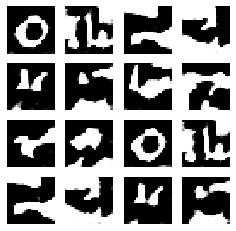

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.780 | Loss: 1.676



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-31
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-268


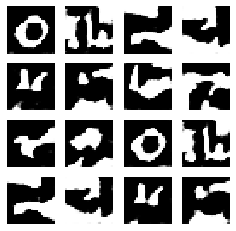

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.780 | Loss: 1.676



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-32
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-269


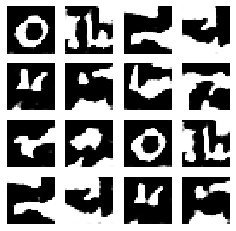

G Train Acc:     0.902 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.780 | Loss: 1.676



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-33
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-270


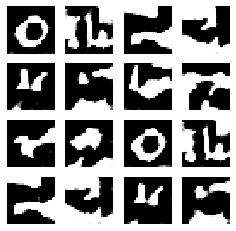

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.780 | Loss: 1.676



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-34
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-271


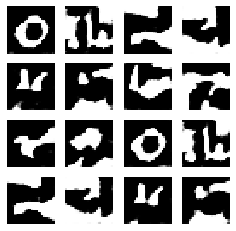

G Train Acc:     0.901 | Loss: 1.560
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.780 | Loss: 1.676



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-35
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-272


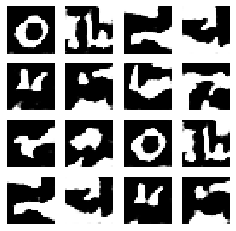

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.780 | Loss: 1.676



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-36
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-273


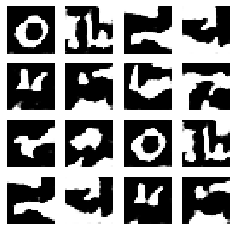

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.780 | Loss: 1.676



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-37
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-274


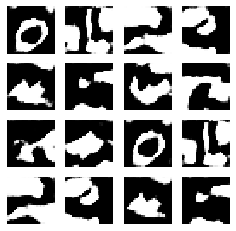

G Train Acc:     0.487 | Loss: 1.975
D Train Acc:     NaN   | Loss: 0.995
D Test Accuracy: 0.103 | Loss: 2.357

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-275


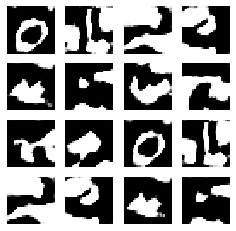

G Train Acc:     0.899 | Loss: 1.562
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-27
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-276


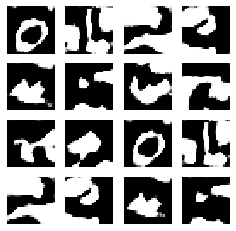

G Train Acc:     0.899 | Loss: 1.562
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-28
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-277


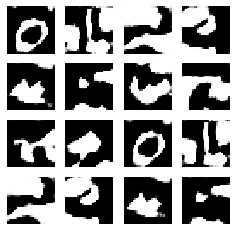

G Train Acc:     0.902 | Loss: 1.559
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-29
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-278


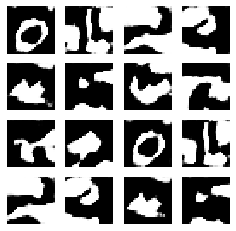

G Train Acc:     0.901 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-30
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-279


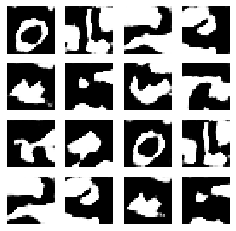

G Train Acc:     0.900 | Loss: 1.561
D Train Acc:     NaN   | Loss: 1.251
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-31
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-280


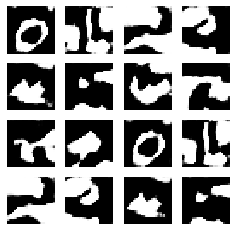

G Train Acc:     0.901 | Loss: 1.560
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-32
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-281


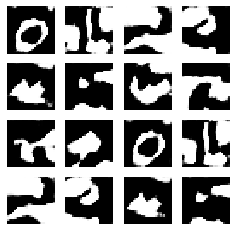

G Train Acc:     0.901 | Loss: 1.560
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-33
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-282


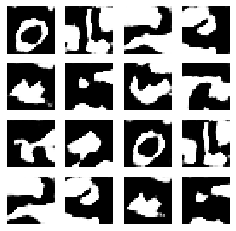

G Train Acc:     0.899 | Loss: 1.563
D Train Acc:     NaN   | Loss: 1.250
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-34
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-283


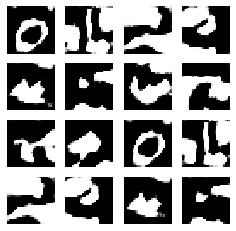

G Train Acc:     0.901 | Loss: 1.560
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-35
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-284


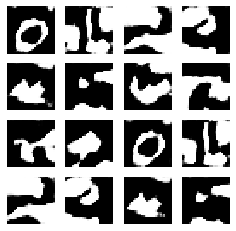

G Train Acc:     0.903 | Loss: 1.558
D Train Acc:     NaN   | Loss: 1.253
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-36
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-285


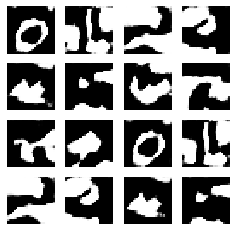

G Train Acc:     0.898 | Loss: 1.563
D Train Acc:     NaN   | Loss: 1.250
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-37
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-286


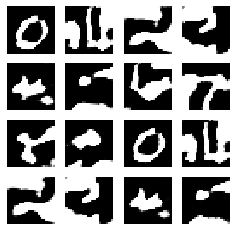

G Train Acc:     0.451 | Loss: 2.010
D Train Acc:     NaN   | Loss: 0.973
D Test Accuracy: 0.103 | Loss: 2.357

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-287


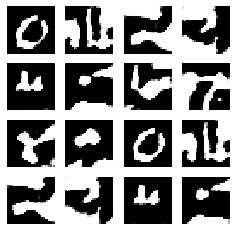

G Train Acc:     0.881 | Loss: 1.580
D Train Acc:     NaN   | Loss: 1.240
D Test Accuracy: 0.343 | Loss: 2.113

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-288


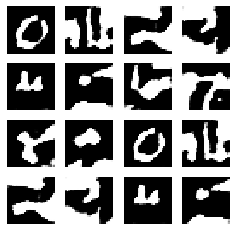

G Train Acc:     0.907 | Loss: 1.554
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.311 | Loss: 2.144

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-289


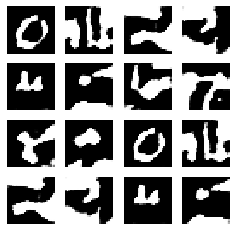

G Train Acc:     0.908 | Loss: 1.553
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.742 | Loss: 1.714

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-290


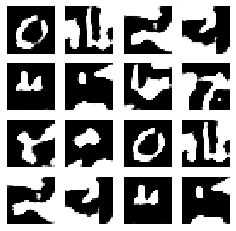

G Train Acc:     0.901 | Loss: 1.560
D Train Acc:     NaN   | Loss: 1.252
D Test Accuracy: 0.628 | Loss: 1.825

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-291


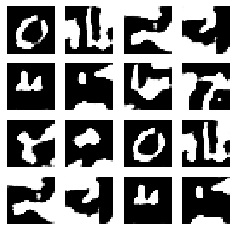

G Train Acc:     0.905 | Loss: 1.556
D Train Acc:     NaN   | Loss: 1.254
D Test Accuracy: 0.460 | Loss: 1.996

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-292


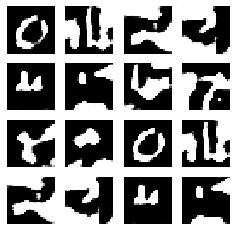

G Train Acc:     0.911 | Loss: 1.551
D Train Acc:     NaN   | Loss: 1.258
D Test Accuracy: 0.641 | Loss: 1.814

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-293


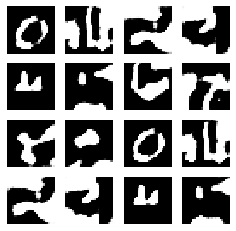

G Train Acc:     0.833 | Loss: 1.628
D Train Acc:     NaN   | Loss: 1.210
D Test Accuracy: 0.324 | Loss: 2.132

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-294


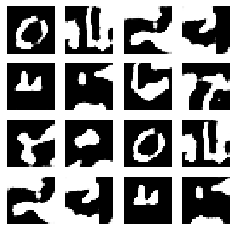

G Train Acc:     0.829 | Loss: 1.632
D Train Acc:     NaN   | Loss: 1.207
D Test Accuracy: 0.505 | Loss: 1.947

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-295


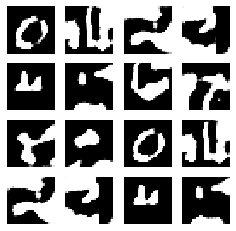

G Train Acc:     0.910 | Loss: 1.551
D Train Acc:     NaN   | Loss: 1.258
D Test Accuracy: 0.452 | Loss: 2.002

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-296


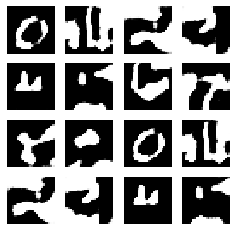

G Train Acc:     0.916 | Loss: 1.545
D Train Acc:     NaN   | Loss: 1.261
D Test Accuracy: 0.376 | Loss: 2.078

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-297


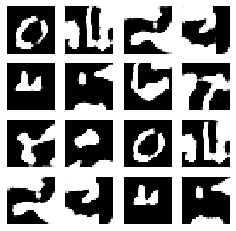

G Train Acc:     0.913 | Loss: 1.548
D Train Acc:     NaN   | Loss: 1.259
D Test Accuracy: 0.337 | Loss: 2.119

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-298


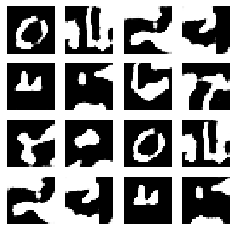

G Train Acc:     0.908 | Loss: 1.553
D Train Acc:     NaN   | Loss: 1.256
D Test Accuracy: 0.364 | Loss: 2.090

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-299


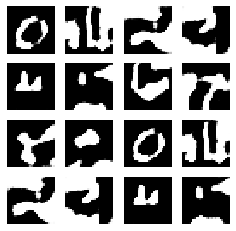

G Train Acc:     0.914 | Loss: 1.547
D Train Acc:     NaN   | Loss: 1.260
D Test Accuracy: 0.503 | Loss: 1.948

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-26
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-300


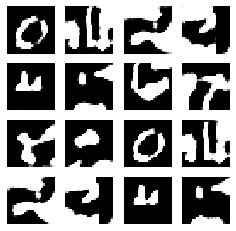

G Train Acc:     0.920 | Loss: 1.542
D Train Acc:     NaN   | Loss: 1.263
D Test Accuracy: 0.332 | Loss: 2.123

Restored D to latest checkpoint from checkpoints\default\blackbox_checkpoint
D Test Accuracy: 0.762 | Loss: 1.695



In [21]:
slg = test_GAN(slg)

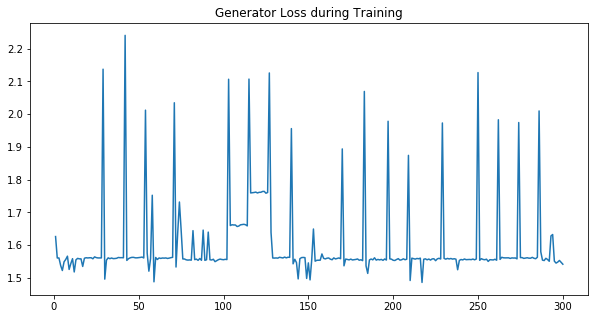

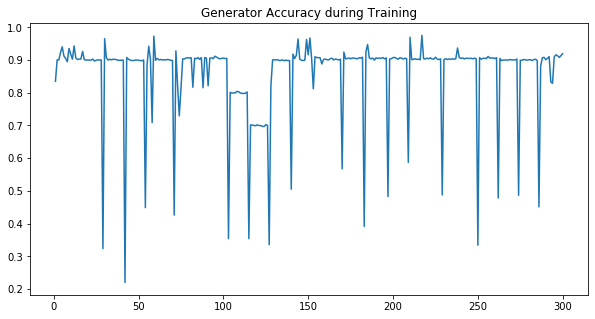

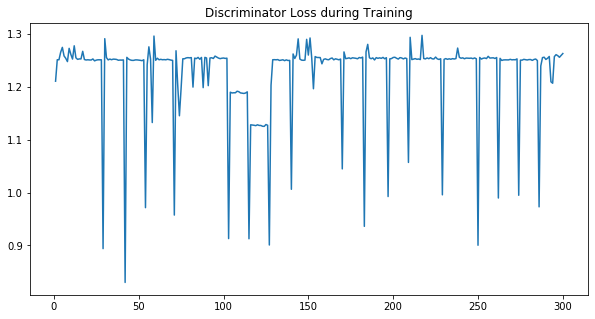

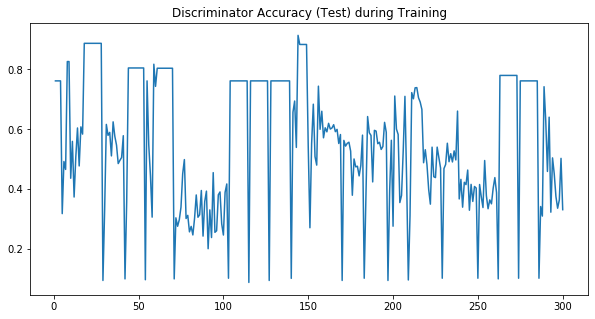

In [22]:
slg.plot_gan_training()

In [23]:
# slg = SystemTrainer(split_training_params, noise_dim, gan_batch_size, gan_epochs, use_blackbox=False)
# slg.train_sl()